# Elections avec des votants représentés dans $\mathbb R^n$

## 1. Introduction 

Ce notebook présente un nouveau **framework** dans le domaine du choix social. Dans une éléction classique, on prends en compte les préfèrences de chaque élécteur, mais on ne tient pas compte d'informations complémentaires sur les électeurs. Les seuls informations qui sont déjà utilisé dans certaines régles de votes sont des poids associés à chaque électeurs.

On introduit ici la representation vectorielle des électeurs. En effet, il n'est pas rare aujourd'hui, à l'ére d'internet, que les produits ou les utilisateurs soient **représentés par un vecteur**.

Ainsi, on peut transposer les problamétiques des règles de votes classique à ce nouveau framework, notamment pour les régles multiwinners : Quel régles vont satisfaire les critères d'**excellence**, de **diversité** ou de **proportionnalité** ?


### Exemples

De plus en plus d’attention est portée sur **la représentation de la diversité**. Les recherches faites à ce sujet cherchent en général a atteindre une diversité chez *les candidats élus* (parité homme/femme par exemple). Ici, ce sont les électeurs et non les candidats qui sont caractérisés, cet objectif ne peut donc être visé directement. 

Imaginons que l'on veuille prendre une décision pour la ville de Paris. Si l’on fait une élection simple, la décision qui convient **à la majorité uniforme** sera probablement choisie. On aimerait, en utilisant des vecteurs représentants les électeurs, que la décision prise convienne **au plus de communautés** possibles, qu’elles soient *minoritaires* ou *majoritaires*.

Quelques autres exemples :

* **Aggregation d’algorithmes/d’opinions :** On souhaite prendre une décision importante et on interroge des économistes, des sociologues et des scientifiques. Idéalement, on voudrait que la décision finale soit satisfaisante pour des spécialistes de chaque groupe.


* **Netflix achète les droits d’un film :** Netflix veut acheter les droits de nouveaux  films pour sa plateforme. Il dispose des embeddings de ses utilisateurs et de leurs préférences sur les nouveaux films à acheter et doit décider lesquels acheter en perdant le moins d’abonnés.


* **Outil de recherche (Guizmo):** On fait une requête dans un outils de recherches avec plusieurs mots (par exemple *“mammifère allaiter ovipare”*).  Les mots sont représentés par des embeddings. On voudrait une page qui utilise tous nos mots, ou au moins toutes les familles de mots.


<img src="../Figures/schémas_embeddings/schema1.jpg">

### Plan

**I. Introduction**

**II. Préliminaires**

**III. Genérer le profil**

**IV. Règles single-winner**

**V. Règles multi-winner**

**VI. The moving Voter**


### TODO

1. Lien entre la matrice de features et la SVD, par le biais de la pseudo inverse
2. Continuer à travailler sur le volume lié à la SVD, Interpretation phyisque etc.
3. Dépipauter encore le multiwinner, en s'inspirant de SVD : 
    * Soit on requiert une condition qui permet d'avoir des poids = 0 à la fin
    * Soit on pénalise volontairement des gens qui ont rien demandé
4. Algo pour manipuler ? Indique à quel point l'embedding est important dans la règle de vote.
6. Manipuler les scores ? Mettre $(1,0,0...,0)$ optimal ?
9. Weights : puissance. Quota : n/(k+1) -> exclusion, alors pas très grave n/k -> consensus, mais il faut en avoir 0 à la fin.

### Done

1. [Rsrch] Propriétés
2. [Implem] Qualité de features
3. [Implem] Iter SVD avec d'autres règles que np.max
4. [Implem] Différents quota dans Iter

## 2. Préliminaires

### Le *Setup* mathématique

Soit $\mathcal V = (v_1,\cdots,v_n)$ un ensemble de $|\mathcal V| = n$ **electeurs**. Chaque électeurs est associé à un vecteur d'embeddings dans $\mathbb R^d$ de dimension $d$. On note $\vec{v^i}$ l'embedding de $v_i$. On suppose ici que les vecteurs sont tous positifs et de norme $1$ : $\forall i, \left \| \vec{v^i} \right \| = 1$ et $\vec{v^i} \ge 0$.

Soit $\mathcal C = (c_1,\cdots,c_m)$ un ensemble de $|\mathcal C| = m$ **candidats**. Les électeurs ont des préférences sur $\mathcal C$. Ces préférences peuvent s'exprimer au travers d'un **ranking**, d'un **approval** ou bien d'un **scoring**. On considére ici le cas le plus général ou chaque votant $v_i$ donne un score $s_i(c) \in [0,1]$ à chaque candidat $c \in \mathcal C$.

Ainsi, le profil de vote pour une élection est noté $P = ( (\vec{v^1},s_1), \cdots, (\vec{v^n},s_n) )$ et on note $\mathcal P$ l'ensemble des profils possible.

Une règle de vote est une fonction $r$ qui associe à tout profil un ou plusieurs gagnants. On note $r(P)$ ou $r(V,S)$.

On utiliseras également la notation $V$ pour parler de la matrice des électeurs 
$$
V =
\begin{pmatrix}
\vec{v^1} \\
\vdots \\
\vec{v^n}
\end{pmatrix}
$$

On note également $S$ la matrice des scores
$$
S = \begin{pmatrix}
s_1(c_1) & \cdots & s_1(c_m) \\
\vdots & \ddots & \vdots \\
s_n(c_1) & \cdots & s_n(c_m)
\end{pmatrix}
$$

Enfin, on note $V(c)$ la matrice des électeurs pondérés par les scores donnés au candidat $c$ :

$$
V(c) = \begin{pmatrix}
s_1(c)\vec{v^1} \\
\vdots \\
s_n(c)\vec{v^n} 
\end{pmatrix}
$$

### Remarques préliminaires

On ne reviendra pas en détail sur toutes les règles (single winner ou multi winner) possibles si l’**on n’utilise pas** la représentation géométrique de chaque électeurs, car cela a déjà été étudié.

Si on utilise les embeddings des électeurs, on risque très fortement de briser **l’anonymité** telle qu'elle est habituellement définie. Cependant, la propriété de **neutralité** est conservée.

Les embeddings peuvent être totalement **indépendants** des préférences ou alors peuvent être **induits des vecteurs de scoring** de chaque votant (avec PCA par exemple).


### Quelques propriétés des règles de votes :

1. <ins>**Anonymité faible (AF)**</ins> : Le résultat ne change pas si on échange l'embedding ET le scoring de deux votants. 


2. <ins>**Invariance par homotéthie du score (IHs)**</ins> : Le résultat ne change pas si on multiplie tous les scores par un scalaire.


3. <ins>**Invariance par homotéthie des embeddings (IHe)**</ins> : Le résultat ne change pas si on multiplie tous les embeddings par un sclaire.


4. <ins>**Continuité (C)**</ins> : Continuité de la fonction *r* en fonction de $V$ et de $S$. En general cela est continue, mais parfois pas lors d'un passage à 0 et une réduction de dimension.


5. <ins>**Invariance par Rotation (IR)**</ins> : Le résultat ne change pas si on multiplie la matrice $V$ par une matrice de rotation $Q$ : $r(V,S) = r(QV,S)$.


6. <ins>**Voters Clone-Proofness (CP)**</ins> : Si on ajoute un clone parfait d'un électeur déjà existant, alors les scores des candidats ne changent pas (version forte) / le classement des candidats ne change pas (version faible).


7. <ins>**Invariance par transformation linéaire du score (LTs)**</ins> : Le résultat ne change pas si on applique une transformation linéaire aux scores. A priori, aucune des règles évoquées ci dessous ne vérifie cette propriété. Algo de manipulation par l'organisateur ?



8. <ins>**Pareto-efficency (PE)**</ins> Si il existe deux candidats $c_1$ et $c_2$ tels que $\forall i, s_i(c_1) \ge s_i(c_2)$ et $\exists i, s_i(c_1) > s_i(c_2)$ alors $c_2$ ne peut pas gagner. 


9. <ins>**Invariance par augmentation de la dimension (IAD)**</ins> Si on place notre espace de dimension $d$ dans un espace de dimension $d' > d$, les vainqueurs restent les mêmes. La plupart du temps ça marche bien la plupart du temps.


10. <ins>**Monotonie (M)**</ins> Si $x$ est vainqueur et qu'un électeur augmente le score de $x$, alors $x$ est toujours vainqueur.


11. <ins>**Agenda Manipulability (AM)**</ins> Can we change the embeddings of voters such that our candidate win ?


|Family    | Rule     | AF| IHs| IHe | LTs |C     | IR | CP | PE | IAD| M | AM |
|----------|----------|---|----|-----|-----|------|----|----|----|----|---|----|
| Geometric| Zonotope | V | V  | V   | X   | V*   | V  | X  | V  | V  | V |    |
| SVD Based| Produit  | V | V  | V   | X   | V*   | V  | X  | V  | V  | V |    |
| SVD Based| Somme    | V | V  | V   | X   | V    | V  | X  | V  | V  | V |    |
| SVD Based| Minimum  | V | V  | V   | X   | V*   | V  | X  | V  | V  | V | P? |
| SVD Based| Maximum  | V | V  | V   | X   | V    | V  | X  | V  | V  | V |    |
| Features | Cosinus  | V | V  | V   | X   | V    | V  | X  | V  | V  | V |    |
| Features | Sinus    | V | V  | V   | X   | V    | V  | X  | V  | V  | V |    |
| Features | SquareSum| V | V  | V   | X   | V    | V  | X  | V  | V  | V |    |


A ces propriétées s'ajoutent les nombreuses propriétées classiques des règles de votes single et multi winners.


Enfin, on s'intéresse également à ce qu'il se passe dans **le cas particulier** des <ins>Groupes orthogonaux</ins> :

* Les électeurs sont divisés en $d$ groupes $(G_1,\cdots,G_n)$.
* Au sein de chaque groupe, les électeurs sont coolinéaires.
* Les groupes sont orthogonaux entre eux : $\forall i \ne j, G_i \perp G_j$

#### Commentaires

1. Il existe des règles invariantes par transformation linéaires des embeddings et des scorings ($ax+b$ avec $a > 0$). Par exemple $f(s,v) = (\sum s_i v_i)^t \cdot \left (\begin{matrix} 1 \\ \vdots \\ 1 \end{matrix} \right )$. Alors :

$$ 
f(as+b,v) = (\sum (as_i+b) v_i)^t \cdot \left (\begin{matrix} 1 \\ \vdots \\ 1 \end{matrix} \right ) = af(s,v) + b (\sum v_i)^t \cdot \left (\begin{matrix} 1 \\ \vdots \\ 1 \end{matrix} \right )
$$

$$
f(s,av+b) = (\sum s_i (av_i + b))^t \cdot \left (\begin{matrix} 1 \\ \vdots \\ 1 \end{matrix} \right ) = af(s,v) + (\sum s_i) b^t  \cdot \left (\begin{matrix} 1 \\ \vdots \\ 1 \end{matrix} \right )
$$

Puisque $a > 0$, l'ordre des scores sera préservé. En fait, **cela est vrai pour toutes les règles de scores bilinéaires** en $s,v$ (ou linéaire en l'un pour chaque propriété). Cela est aussi vrai pour les règles constantes, mais on choisit de les écarter. De même, on ne prends pas en compte les règles qui sont constante a $s$ fixée (i.e. elle ne dépendent pas des embeddings d'électeurs).

**La réciproque est fausse** (toutes les règles qui vérifient ces propriétés ne sont pas bilinéaire. Par exemple, si on prends la fonction $f$ ci-dessus, alors $g$ définit comme $g(s,v) = f(s,v)^2$ n'est pas bilinéaire mais vérifie bien la stabilité par transformation linéaire.



### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from embedded_voting.Profile import Profile
from embedded_voting.scores import *

np.random.seed(42)

### Fonctions utiles

In [2]:
def rotation_matrix(theta,dim=2):
    '''
    Generate a rotation matrix with angular theta
    '''
    M = np.eye(dim)
    M[0,0] = np.cos(theta)
    M[0,1] = - np.sin(theta)
    M[1,0] = np.sin(theta)
    M[1,1] = np.cos(theta)
    return M

def np_logsumexp(x):
    return np.log(np.sum(np.exp(x)))

## 3. Generating profiles with scores and embeddings

Dans ce notebook, on va s'amuser à tester nos règles de votes. On va pour cela générer des profils d'embeddings en dimension $2$. Puisque les vecteurs ont une norme un, on utilise simplement des angles entre $0$ et $\pi/2$ pour les représenter. 

Pour faciliter la representation, on les multiplies par $4$ pour les représenter sur un cercle entier, mais il faut garder en tête que les vecteurs à la fin du cercle trigonométrique sont orthogonaux à ceux au début du cercle trigonométrique.

In [3]:
p = Profile(6,3)
p.add_group(50,[0.15,0.15,0.85],[0.1,0.1,0.9,0.7,0.4,0.5],color="red")
p.add_group(25,[0.85,0.15,0.15],[0.1,0.9,0.1,0.4,0.7,0.5],color="blue")
p.add_group(25,[0.15,0.85,0.15],[0.9,0.1,0.1,0.4,0.7,0.5],color="green")

### Représenter le profil de vote

Dans ce notebook, on va s'amuser avec le profil de vote suivant :

* En <font color=red>rouge</font>, un groupe assez homogène de 50 électeurs.
* En <font color=blue>bleu</font> et en <font color=green>vert</font>, deux groupes homogènes de 25 électeurs.

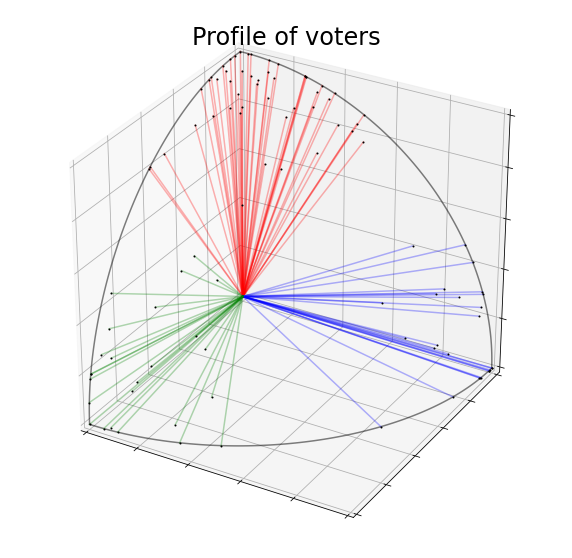

In [16]:
p.plot_profile_3D()

### Représenter les scores des candidats

Chaque candidat peut être représenter dans le même cercle, en multipliant les vecteurs des électeurs par le score qu'il donne au candidat. On considère ici $5$ candidats :

* <ins>Candidat 1</ins> : Favoris des <font color=green>verts</font>.
* <ins>Candidat 2</ins> : Favoris des <font color=blue>bleus</font>.
* <ins>Candidat 3</ins> : Favoris des <font color=red>rouges</font>.
* <ins>Candidat 4</ins> : Consensuel, légérement préféré par les <font color=red>rouge</font>.
* <ins>Candidat 5</ins> : Consensuel, légérement préféré par les <font color=green>verts</font> et les <font color=blue>bleus</font>.
* <ins>Candidat 6</ins> : Consensus parfait.

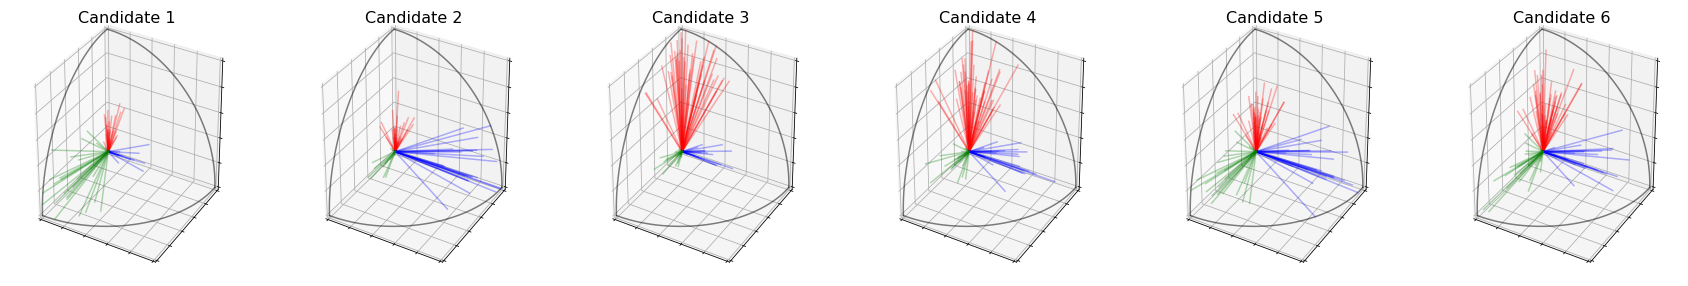

In [17]:
p.plot_cands_3D()

## 4. Règles single-winner (et multi-winner avec objectif d'excellence)

### 4.A. Règles géométrique

La première idée est de calculer d'une certaine manière le *"volume"* de l'ensemble des vecteurs. Les deux règles proposées sont les suivantes:

#### Le volume de l'éllipsoïde

1. Le score d'un candidat $c$ est égal au volume de la plus petite **ellipsoïde** qui contient tous les vecteurs de $V(c)$.

Cependant, les techniques pour calculer ces volumes ont une trop **grande complexité**. Il existe des algorithmes d'approximations, mais ils sont assez complexes également.

<ins>Propriétés</ins> : Cette règle vérifie les propriétés d'**invariance par changement de base**, et de **clone-proofness** + **pareto efficency**

<ins>Cas des groupes orthogonaux</ins> : La règle de l'éllipsoïde renvoit $\prod_k (\max_{v_i \in G_k} s_i)$

#### Le volume du zonotope

2. Le score d'un candidat $c$ est égal au volume du **Zonotope** généré par les vecteurs de $V(c)$. 

Cependant, ce volume est #P-Hard à calculer. Le zonotope est en fait l'image de l'hypercube dans $\mathbb R^n$ par la matrice $V(c)$. Notamment, on peut le calculer ainsi :

$$ 
Vol(Z) = \sum_{1 \le i_1 < \cdots < i_d \le n}|det(V(c)^{i_1,\cdots,i_d})|
$$

<ins>Propriétés</ins> : 

 * **IH** : Evident, si tous les vecteurs subissent une homotéthie, le volume qu'ils engendrent va subir la même homotéthie.
 * **LTs** : Avec un profil de deux électeurs $a(1,0)$ et $b(0,1)$ tel que $s_a(c_1) = 1, s_b(c_1) = 0$ et $s_a(c_2) = s_b(c_2) = 0.1$. Alors le volume initial est $1 \times 0 = 0$ pour $c_1$ et $0.1 \times 0.1$ pour $c_2$. Le volume apès modification $s \rightarrow 0.1s + 0.9$ est $1 \times 0.9 = 0.9$ pour $c_1$ et $0.91 \times 0.91 = 0.8281$ pour $c_2$. Cette règle ne vérifie donc pas LTs.
 * **C** : Continuité, sauf lorsqu'on perd une dimension car le rang change et le volume va être calculé différemment
 * **IR** : Evident par définition
 * **CP** : Ne vérifie pas clone proofness de façon claire
 * **PE** : Le zonotope du candidat pareto dominé est inclus dans celui du candidat dominant
 * **IAD** : Evident
 * **M** : Le volume du zonotope ne peux qu'augmenter lorsque l'on augmente un score

<ins>Cas des groupes orthogonaux</ins> : Le volume du zootope est $\prod_k (\sum{v_i \in G_k} s_i)$

In [6]:
zonotope = ZonotopeRule(p)

[602.5415607886202, 544.5623809540135, 1081.1161804549195, 5278.114847919959, 7137.855789441648, 5037.869071045621]
[4 3 5 2 0 1]
4


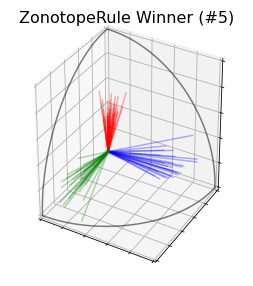

In [7]:
print(zonotope.scores_)
print(zonotope.ranking_)
print(zonotope.winner_)
zonotope.plot_winner()

### 4.B. Régles des valeurs singulières

On considère cette fois la décomposition en valeurs singulières des matrices $V(c)$ :

$$
V(c) = U\Sigma V
$$

Et on s'intéresse particuliérement aux valeurs singulières de $V(c)$ : $\sigma^c_1 \ge \cdots \sigma^c_d$, et au rang $r^c \le d$ de la matrice.

<ins>Propriétés</ins> : Puisque la décomposition en valeurs singulière est stable par rotation alors les règles basées sur les valeurs singulières vérifient la propriété de **stabilité par changement de base**. + **pareto efficency** (?)


#### Produit

On sait que $\prod_i \sigma^c_i = \sqrt{\det(V(c)^tV(c))}$. 

Plus généralement, on trouve dans la littérature une définition du volume d'une matrice comme égal au **produit des valeurs singulières** non nulles $\prod_{i=1}^r \sigma^c_i $.

En effet, d'après la décomposition en valeurs signulières, on a deux bases orthonormales $(u_1,...,u_r) \in \mathbb R^n$ et $(v_1,...,v_r)\in \mathbb R^d $ telles que $\forall i, V(c)u_i = \sigma_i v_i$. Le cube engendré par les vecteurs $(u_1,...,u_n)$ est de volume $1$ car c'est une base orthonormale. La matrice envoit donc un cube de volume $1$ sur un polytope de volume $vol(V(c)) = \prod_{i =1}^r \sigma^c_i$. Puisque les valeurs singulières sont invariantes par rotation, tout cube unité sera envoyé vers un cube de volume $vol(V(c)) = \prod_{i =1}^r \sigma^c_i$.

De plus, on à l'égalité suivante :

$$ 
\prod_{i=1}^d \sigma^c_i = \sqrt{\sum_{1 \le i_1 < \cdots < i_d \le n}(det(V(c)^{i_1,\cdots,i_d}))^2}
$$


<ins>Cas des groupes orthogonaux :</ins> $\prod_{i=1}^r \sigma^c_i = \prod_k \sqrt{\sum_{v_i \in G_k} s_i(c)^2}$.

<ins>Remarque :</ins> En considérant $V(c)$ comme la matrice

$$
V_{sqrt}(c) = \begin{pmatrix}
\sqrt{s_1(c)}\vec{v^1} \\
\vdots \\
\sqrt{s_n(c)}\vec{v^n} 
\end{pmatrix}
$$

On retrouve $(\prod_{i=1}^r \sigma^c_i)^2 = \prod_k \sum_{v_i \in G_k} s_i(c)$.

##### Essayons de comprendre cette histoire de Volume...

On a une cube dans $\mathbb R^3$ qui corresponds à 3 voteurs orthogonaux. C'est la matrice $V$ de la SVD. On a $\forall 1 \le i \le 3, V(c)V_i = \sigma_iU_i$ où $U_i$ est un vecteur de ponderation sur les électeurs, de normes $1$. De plus, les $U_i$ sont orthogonaux. Cela signifie qu'en prenant le projeté sur chacune des coordonnées du cube, on retrouve un cube dans l'espace des votants de volume $\prod \sigma_i$. Mais ce n'est pas vraiment clair ce qu'est un cube de dimension 3 dans l'espace des votants ?

Considérons l'équation $V(c)^tV(c)u_i = \sigma_i u_i$. En faisant le calcul on obtient $\sum_j s_j\vec{v_j} <s_j\vec{v_j},\vec{u_i}> = \sigma_i \vec{u_i}$ and then since $u_i$ is of norm $1$ :

$$
\sigma_i^2 = \sum_j <s_j\vec{v_j},\vec{u_i}>^2 = \sum_j <\vec{v(c)_j},\vec{u_i}>^2
$$

On projette ainsi le score sur chaque composante de la base otrhonormée, en quelque sorte. Mais j'ai encore du mal à interpreter cela en terme de volume.

Dans l'autre sens, si on prends 3 pondérations orthonormales dans l'espace des électeurs $\mathbb R^n$, chaque pondération donne un *électeur moyen* tel que les électeur moyen obtenus sont orthogonaux et attribuent des scores $\sigma_i$.


<ins>Propriétés</ins> : 

 * **IH** : Evident, si tous les vecteurs subissent une homotéthie, les déterminants vont subir la même homotéthie.
 * **LTs** : Voir Règle du Zonotope
 * **C** : Continuité, sauf lorsqu'on perd une dimension car le rang change et le volume va être calculé différemment
 * **IR** : Evident
 * **CP** : Ne vérifie pas clone proofness de façon claire
 * **PE** : Tous les volumes dans la somme ci dessus seront logiquement plus grands pour le candidat dominant.
 * **IAD** : Evident
 * **M** : Les volumes dans la sommes ci dessus ne vont qu'augmenter.

####  Somme

On sait que $\left \| V(c) \right \|_{tr} = \sum_{i=1}^d \sigma^c_i = tr(\sqrt{V(c)^tV(c)})$.

<ins>Cas des groupes orthogonaux :</ins> $\sum_{i=1}^d \sigma^c_i = \sum_k \sqrt{\sum_{v_i \in G_k} s_i(c)^2}$.


<ins>Propriétés</ins> : 

 * **IH** : Clair par decomposition SVD
 * **LTs** : Non car il y a un carré (ex groupes orthogonaux)
 * **C** :  Clair
 * **IR** : Evident par definition
 * **CP** : Ne verifie par la clone proofness
 * **PE** : $V(c_1) > V(c_2)$ donc $tr(\sqrt{V(c_1)^tV(c_1)}) > tr(\sqrt{V(C_2)^tV(c_2)})$
 * **IAD** : Clair, cela ne rajoute qu'une valeur singulière nulle
 * **M** : Voir **PE**

####  Maximum

On sait que $\left \| V(c) \right \|_2 = \sigma^c_1 = \max_{u} \dfrac{\left \| V(c)u \right \|}{\left \|u\right \|}$.

<ins>Cas des groupes orthogonaux :</ins> $\sigma_1 = \max_k \sqrt{\sum_{v_i \in G_k} s_i(c)^2}$.

<ins>Propriétés</ins> : 

 * **IH** : Clair par decomposition SVD
 * **LTs** : Non car il y a un carré (ex groupes orthogonaux)
 * **C** :  Clair
 * **IR** : Evident par definition
 * **CP** : Ne verifie par la clone proofness
 * **PE** : $V(c_1) > V(c_2)$ donc $\forall u, V(c_1)u > V(c_2)u$ donc la règle est pareto efficace
 * **IAD** : Clair, cela ne rajoute qu'une valeur singulière nulle
 * **Mon** : Voire **PE**

#### Minimum

Le minimum ne fait pas vraiment de sens, on devrait plutot considérer les vecteurs $(\sigma^c_n,\cdots,\sigma^c_1)$ et les classer dans l'ordre lexicographique.


<ins>Propriétés</ins> : 

 * **IH** : Clair par decomposition SVD
 * **LTs** : Non car il y a un carré (ex groupes orthogonaux)
 * **C** :  Pas en 0 car on change de rang.
 * **IR** : Evident par definition
 * **CP** : Ne verifie par la clone proofness
 * **PE** : By the MinMax Theorem of singular values
 * **IAD** : Clair, cela ne rajoute qu'une valeur singulière nulle
 * **M** : By the MinMax Theorem of singular values


#### Autres normes connues

* **Norme de Frobenius :** $\left \| V(c) \right \|_F = \sqrt{\sum_i (\sigma^c_i)^2}$

<ins>Cas extrême :</ins> $\left \| V(c) \right \|_F  = \sqrt{\sum_{i} s_i(c)^2}$

* **Schaten p-Norm :** $\left \| V(c) \right \|_{S,p} = (\sum_i (\sigma^c_i)^p)^{1/p}$
* **Ky Fan k-Norm :** $\left \| V(c) \right \|_{K,k} = \sum_{i=1}^{k} \sigma^c_i$


SANS RACINE
Prod : [3.707685491676604, 3.4664500002365237, 4.99926490045891, 20.666229326104702, 31.494527891873535, 21.567855565758062]
Ranking :  [4 5 3 2 0 1]
Sum : [6.376568877135809, 6.1701412912816505, 8.163703132046779, 9.175675526895521, 9.788813180462967, 8.718323284754923]
Ranking :  [4 3 5 2 0 1]
Min : [0.7108509519337003, 0.8234587249328131, 0.8043359739153397, 1.8363326378216887, 2.398286451624713, 2.0993366097630037]
Ranking :  [4 5 3 1 2 0]
Max : [4.508940395571248, 4.3871474487049635, 6.386097691635351, 5.157089099669716, 4.41836456301445, 4.133564505882753]
Ranking :  [2 3 0 4 1 5]
LSE : [4.564774366811949, 4.446169353863123, 6.394288987627532, 5.240677515921559, 4.7317932461119145, 4.4136088031167695]
Ranking :  [2 3 4 0 1 5]


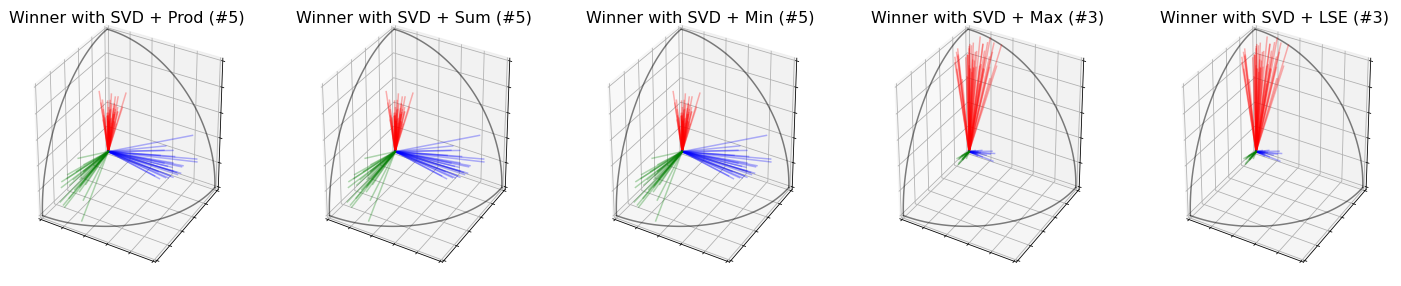

AVEC RACINE
Prod : [16.80313540108208, 16.09573226166585, 17.230696380370674, 54.20062338511706, 66.9861284329738, 55.24677238415926]
Ranking :  [4 5 3 2 0 1]
Sum : [8.687433686736979, 8.462920813072008, 9.938315089500572, 12.148722134476845, 12.50705001527168, 11.902791778018246]
Ranking :  [4 3 5 2 0 1]
Min : [1.467379347678337, 1.626646640688784, 1.4717073290784348, 2.725802740981245, 3.3902972019582487, 2.9300236698294224]
Ranking :  [4 5 3 1 2 0]
Max : [4.867475876837164, 4.755530800728121, 6.7258723896319275, 6.232503101629743, 5.568627750225731, 5.614320438972898]
Ranking :  [2 3 5 4 0 1]
LSE : [4.975649562764895, 4.862309585842248, 6.737864741599142, 6.307360911846831, 5.788421058358446, 5.773928689981493]
Ranking :  [2 3 4 5 0 1]


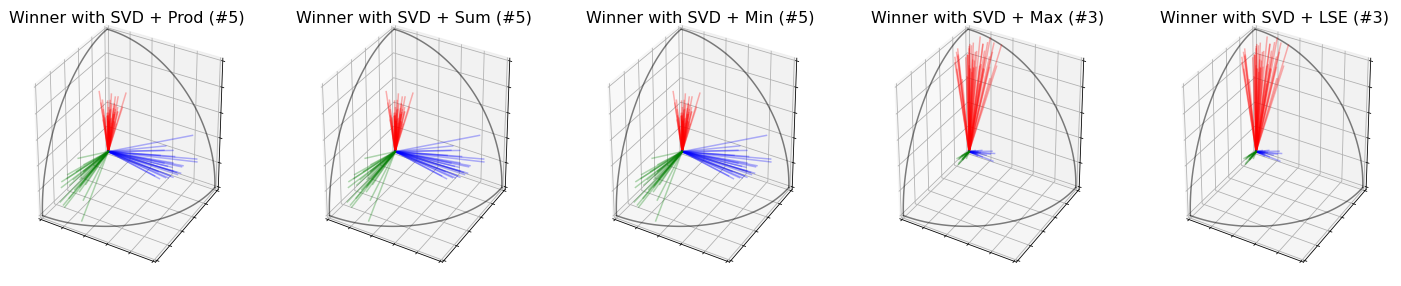

In [8]:
print("SANS RACINE")
svdrule = SVDRule(p)
f_list = [np.prod,np.sum,np.min,np.max,np_logsumexp]
f_name = ["Prod","Sum","Min","Max","LSE"]
svdrule.plot_winners(f_list,f_name,verbose=True)

print("AVEC RACINE")
svdrule = SVDRule(p,rc=True)
f_list = [np.prod,np.sum,np.min,np.max,np_logsumexp]
f_name = ["Prod","Sum","Min","Max","LSE"]
svdrule.plot_winners(f_list,f_name,verbose=True)

### 4.C.  Régles utilisant la matrice de features

Pourquoi ne pas tenter de trouver **les features des candidats** dans l'espaces des électeurs ?

Idéalement, on voudrait une matrice de features $X$ tel que $VX = S$.

On peut chercher par exemple à minimiser $\left \|VX - S \right \|^2$. La matrice $X$ qui minimise cette expression est bien connue : c'est la pseudo inverse de *Moore Penrose* multiplié par la matrice de score $S$:
$$X_{min} = (V^TV)^{-1}V^TS$$

Cette matrice subit les mêmes rotation que $V$, donc on peut se débrouiller pour trouver facilement des règles qui verifient **la stabilité par changement de base**.

<ins> Cas des groupes orthogonaux </ins> : Les features correspondent **aux moyennes des scores** attribués par leur groupe respectifs (sur la coordonnée du groupe).

Ci dessous, la representation des features de chaque candidat dans l'espace des électeurs. On voit que les candidats sont très polarisés.



In [18]:
featuresrule = FeaturesRule(p)

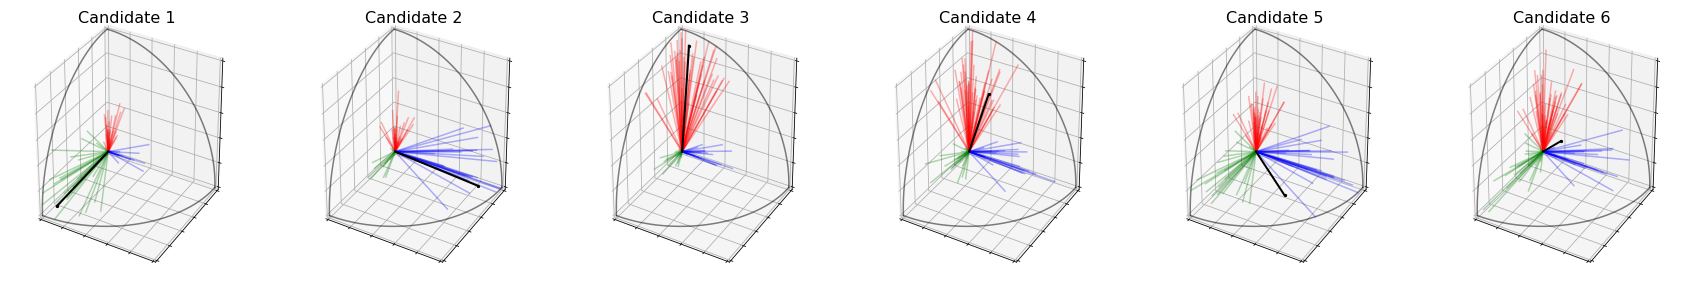

In [19]:
featuresrule.plot_features()

On peut aussi mesurer la qualité des features. Ici, on calcule la déviation carrée moyenne entre le score prédit et le score réél. Plus les groupes d'électeurs sont homogènes et orthogonaux, plus les features seront qualitatives.

In [20]:
featuresrule.features_quality()

array([0.04014573, 0.03237729, 0.03121382, 0.04421332, 0.0463286 ,
       0.04707688])

#### Règles de la somme des carrés.

La seule règle qui exploite directement les features et est stable par changement de base est **la somme des carrés**. Elle peut nous servir de règle single winner mais aussi de base pour trouver une règle itérative par exemple.

<ins>Propriété </ins> : Cette règle est **stable par changement de base**. + **pareto efficency** (?)

<ins>Cas des groupes orthogonaux</ins> : 

$$
score(c) = \sum_{k} \left (\frac{\sum_{v_i \in G_k} s_i}{|G_k|}\right )^2
$$

<ins>Propriétés</ins> : 

 * **IH** : Evident, si tous les scores subissent une homotéthies, alors les features subiront la même. De même pour les homotéthies sur les embeddings.
 * **LTs** : Non, example dans le cas des groupes orthogonaux.
 * **C** : Continue
 * **IR** : Evident par définition
 * **CP** : Pas clone proof
 * **PE** : Evident par définition de la matrice de features (operation linéaires)
 * **IAD** : Le coefficient sera 0 dans la nouvelle dimension pour tous les vecteurs de features
 * **M** : Evident par definition de la matrice de features (operation linéaires)

#### Règles trigonométriques

En renormalisant le vecteurs, on prends la somme ou le produit (equivalent à la somme des logs) des cosinus/sinus. Si on note $f_c$ le vecteur de feature et $f^*_c$ la version normalisée, alors on a :

$$
score(c) = \sum s_i(c)<\vec{v_i},f^*_c>
$$

On peut remplacer la somme par un produit, et le produit scalaire par $1-<,>$. De plus, on peut aussi multiplier par la norme du vecteur de feature.

<ins>Propriété </ins> : Ces règles sont **stables par changement de base**. + **pareto efficency** (?)

<ins>Remarque </ins> : Est-ce qu'on est obligé de ré-utiliser le score, si l'on prend en compre qu'il est déjà utilisé pour calculer la matrice de features ? On obtiendrais une règle **stable par transformation linéaire des scores**. Oui, mais on obtient des résultats mauvais (voir ci-dessous quand *prod_score* est **False**)

<ins>Cas des groupes orthogonaux</ins> : Le résultat est peu intuitif

* Pour le cosinus + Somme

$$
score(c) = \sum_{k} \frac{(\sum_{v_i \in G_k} s_i)^2}{|G_k|} 
$$

* Pour le sinus + Somme 

$$
score(c) = (\sum_{i} s_i) - \sum_{k} \frac{(\sum_{v_i \in G_k} s_i)^2}{|G_k|} 
$$


<ins>Propriétés</ins> : 

 * **IH** : Evident, si tous les scores subissent une homotéthies, alors les features subiront la même. De même pour les homotéthies sur les embeddings.
 * **LTs** : Non, exemple dans le cas des groupes orthogonaux.
 * **C** : Continue
 * **IR** : Evident par définition
 * **CP** : Pas clone proof
 * **PE** : Evident par définition de la matrice de features (operation linéaires)
 * **IAD** : Le coefficient sera 0 dans la nouvelle dimension pour tous les vecteurs de features
 * **M** : Evident par definition de la matrice de features (operation linéaires)


Cosinus  : [20.773203624999002, 19.661813791623054, 41.142077178290144, 33.79714361020994, 32.75688268881179, 26.301275053111276]
Ranking :  [2 3 4 5 0 1]
Cosinus + Log : [15.614864909697229, 14.81630979661857, 30.24289073632007, 28.29832231466837, 27.306603239154406, 23.214965786313275]
Ranking :  [2 3 4 5 0 1]
Sinus  : [10.60694535749397, 9.928731677401547, 9.29136431690624, 22.65570799975835, 22.3360389126893, 25.083528390980096]
Ranking :  [5 3 4 0 1 2]
Sinus + Log : [9.873410336561465, 9.276408342475015, 8.753806080064264, 20.346021254948422, 20.043883191311732, 22.27450872966542]
Ranking :  [5 3 4 0 1 2]


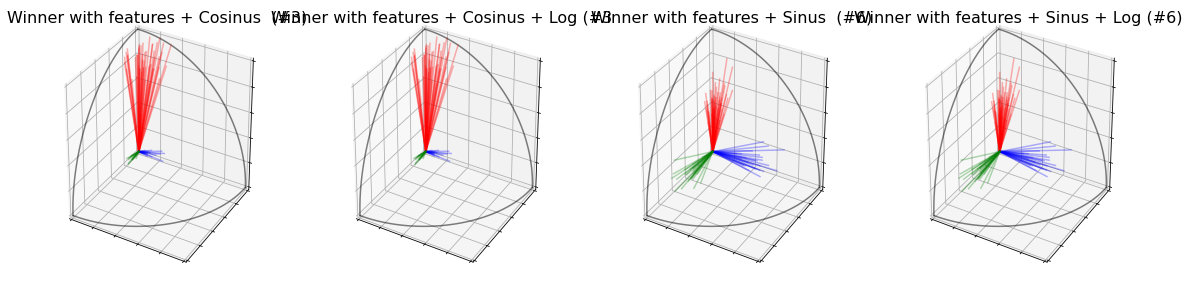

In [9]:
featuresrule.plot_winners(verbose=True)

Cosinus  : [31.10088576407207, 29.272446016425803, 50.22988806076153, 56.14280942248086, 54.62462327058452, 51.03546923798676]
Ranking :  [3 4 5 2 0 1]
Cosinus + Log : [24.183113949863017, 22.74375390358332, 36.95407995753445, 44.08147854633643, 42.96168968691364, 41.17845089031972]
Ranking :  [3 4 5 2 0 1]
Sinus  : [68.89911423592793, 70.72755398357418, 49.77011193923845, 43.85719057751913, 45.37537672941549, 48.96453076201322]
Ranking :  [1 0 2 5 4 3]
Sinus + Log : [50.12063796010071, 51.225516605007606, 36.76214168709917, 35.821350806743645, 36.72364862747624, 39.79625032369772]
Ranking :  [1 0 5 2 4 3]


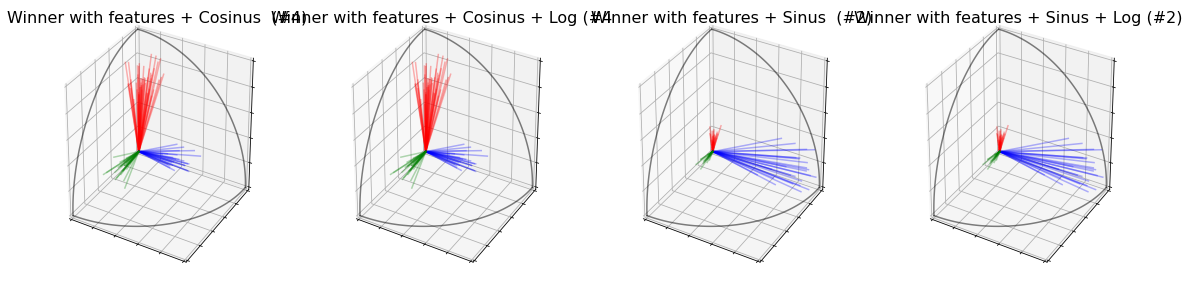

In [10]:
featuresrule = FeaturesRule(p,prod_score=False)
featuresrule.plot_winners(verbose=True)

In [13]:
squarefeaturesrule = SquareFeaturesRule(p)

[0.8226559094687547, 0.8232458336860471, 0.9063111257863664, 0.5562076300872947, 0.7662250538683937, 0.464867527083045]
[2 1 0 4 3 5]


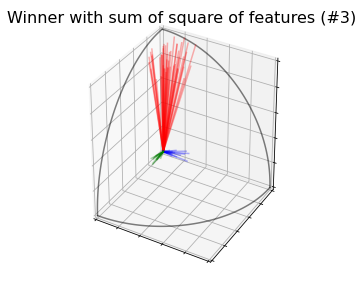

In [14]:
print(squarefeaturesrule.scores_)
print(squarefeaturesrule.ranking_)
squarefeaturesrule.plot_winner()

### 4.$\infty$. Méta Règle

On associe à chaque règle de vote un vecteur d'embedding selon ses caractéristiques (favorise elle la diversité ? etc.) puis on calcule les scores de chaque candidat avec chaque règle de vote, et on applique une règle de vote à ces résultats pour choisir le vainqueur. On peut même faire ça un nombre infini de fois. Va t-on atteindre un moment où toutes les règles donnent le même vainqueur ? :)


# 5. Règles MultiWinner et Proportionalité

Si ce framework s'avère intéressant dans le cas d'une élection single winner, il l'est d'autant plus lorsque l'on souhaite élire **plusieurs vainqueurs** "équitablement" entre les différents groupes. 

On considère habituellement trois principaux critères :

* Critère d'**excellence** : On veut les meileurs candidats (shortlisting par ex), on utilise souvent une single winner rule et on prends les $k$ premiers candidats.

* Critère de **diversité**

* Critère de **proportionnalité**

On s'intéresse ici au critère de **proportionnalité**. Dans le cadre classique, on considère deux types de proportionnalités :

* Dans les élections avec partis, la proportion de vainqueur de chaque parti est proportionnel à la proportion d'électeur de chaque parti.

* Dans une élection sans partis, où chaque candidat est associé à $n/k$ électeurs. On utilise pour cela les règles STV et Monroe.

Ici, c'est une nouvelle forme de proportionnalité. On pourra rapprocher cela a une élection a parti où chaque groupe élit des personnes dans son parti (selon un critère d'excellence) et le nombre de candidats qu'il peut élire est proportionnel à sa taille.

En tout cas, c'est ce qu'on voudrait qu'il se passe dans le cas des groupes orthogonaux.

### Contexte

On veut ici élire un ensemble de $k \le m$ candidats.

### 5.A. Nouveau profil de vote

On a désormais **18** candidats, divisés en **6** catégories, qui sont les mêmes que dans la partie précédente

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from embedded_voting.Profile import Profile
from embedded_voting.scores import *

np.random.seed(42)

In [2]:
p = Profile(18,3)
p.add_group(50,[0.15,0.15,0.85],[0.1]*6 + [0.9]*3 + [0.7]*3 + [0.4]*3 + [0.5]*3,color="red")
p.add_group(25,[0.85,0.15,0.15],[0.1]*3 + [0.9]*3 + [0.1]*3 + [0.4]*3 + [0.7]*3 + [0.5]*3,color="blue")
p.add_group(25,[0.15,0.85,0.15],[0.9]*3 + [0.1]*6 + [0.4]*3 + [0.7]*3 + [0.5]*3,color="green")

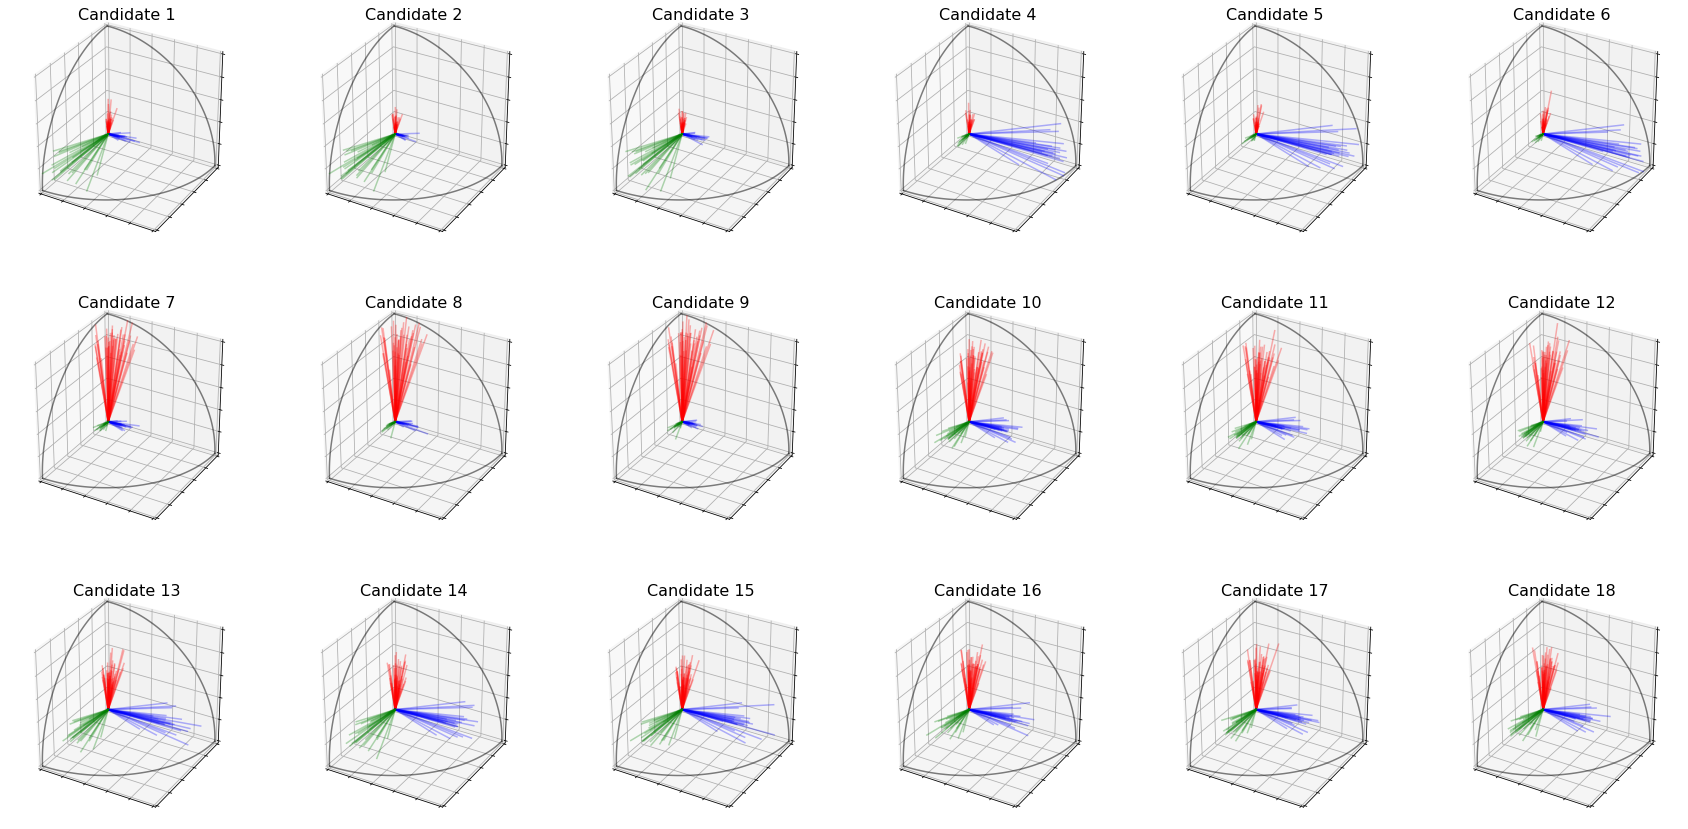

In [3]:
p.plot_cands_3D()

### 5.B IterSVD

La règle STV est connue pour être très proportionnelle et assez simple à mettre en place. L'idée est donc de reprendre les grandes lignes de cette règles, mais en l'adaptant à nos deux familles de règles : Celles basées sur la SVD, et celles basées sur la matrice de features.

Commencons par IterSVD. On veut associer à chaque candidat élu $c$ un ensemble de $\frac{n}{k}$ électeurs.

En faisant la SVD on obtient les valeurs singulière de $V(c)$ : $\sigma^c_1,\cdots,\sigma^c_d$. 

On prends ici le candidat qui maximize $\sigma^c_1$ sa plus grande valeur singulière, puis on s'intéresse au vecteur $\vec{u_1}$ associé à cette valeur singulière.

<ins>**Version discrète :**</ins> On supprime les $\frac{n}{k}$ électeurs dont les embeddings multiplié avec le score qu'ils donnent **maximisent le produit scalaire** avec $\vec{u_1}$. Puis on recommence l'opération avec le nouveau profil. A la fin, on aura élu $k$ candidats et chaque candidat sera **attaché à $\frac{n}{k}$ électeurs**.

<ins>**Version continue :**</ins> Tous les électeurs démarrent l'élection avec un poids 1, à chaque étape, on diminue le poids de l'electeur en fonction de la satisfaction que le candidat lui apporte. L'idée serait de supprimer un poids total de $\frac{n}{k}$ à chaque étape.


<ins>**Cas des groupes orthogonaux :**</ins> Si on a des groupes orthogonaux et $n = qk$ électeurs, avec chaque groupe $G_i$ contenant $qn_i$ electeurs, alors IterSVD retournera précisemment $\forall i$ les $n_i$ candidats préférés du groupe $G_i$. Cependant, j'ai le sentiment que cela fait des choses étranges lorsque $n \ne qk$ dans certains cas particuliers, si on gère mal les cas d'égalités.

<ins>**Remarque :**</ins> Pour des rankings, on peut utiliser Borda et recalculer à chaque fois les scores de Borda sans considérer les candidats éliminés.


<ins>**Proposition**</ins>: Le premier vecteur propre est dans l'orthan positif ou l'orthan negatif.

<ins>**Preuve**</ins>: On sait que 
$$ \sigma^c_1 = \max_{v}{\dfrac{\left \| V(c)v\right \|}{\left \| v\right \|}} $$
Et donc que 

$$ v^1 \in argmax_{v}{\dfrac{\left \| V(c)v\right \|}{\left \| v\right \|}} $$
Or $\left \| v^1\right \| = 1$ donc $$ v^1 \in argmax_{v\text{ s.t. }\left \| v\right \| = 1}{\left \| V(c)v\right \|} = argmax_{v\text{ s.t. }\left \| v\right \| = 1} \sqrt{\sum_{i=1}^n(V(c)_iv)^2}$$

On sait que $V(c) \ge 0$. On sait également par inégalité triangulaire que $\forall i, (V(c)_iv)^2 = (\sum_j V(c)_{i,j}v_j)^2 \le \sum_j (V(c)_{i,j}v_k)^2$ et il y a égalité quand les $v_k$ sont **tous positifs** ou **tous négatifs**. Le vecteur qui maximize donc l'inégalité ci-dessus est donc soit dans l'orthan positif, soit dans l'orthan négatif.

<ins>**Remarque :**</ins> Il faut encore discuter de l'apport de cette règle par rapport à un STV classique.

Ci dessous, on affiche, les vecteurs $u_1$ pour chaque candidat

In [4]:
itersvd = IterSVD(profile=p,k=8)

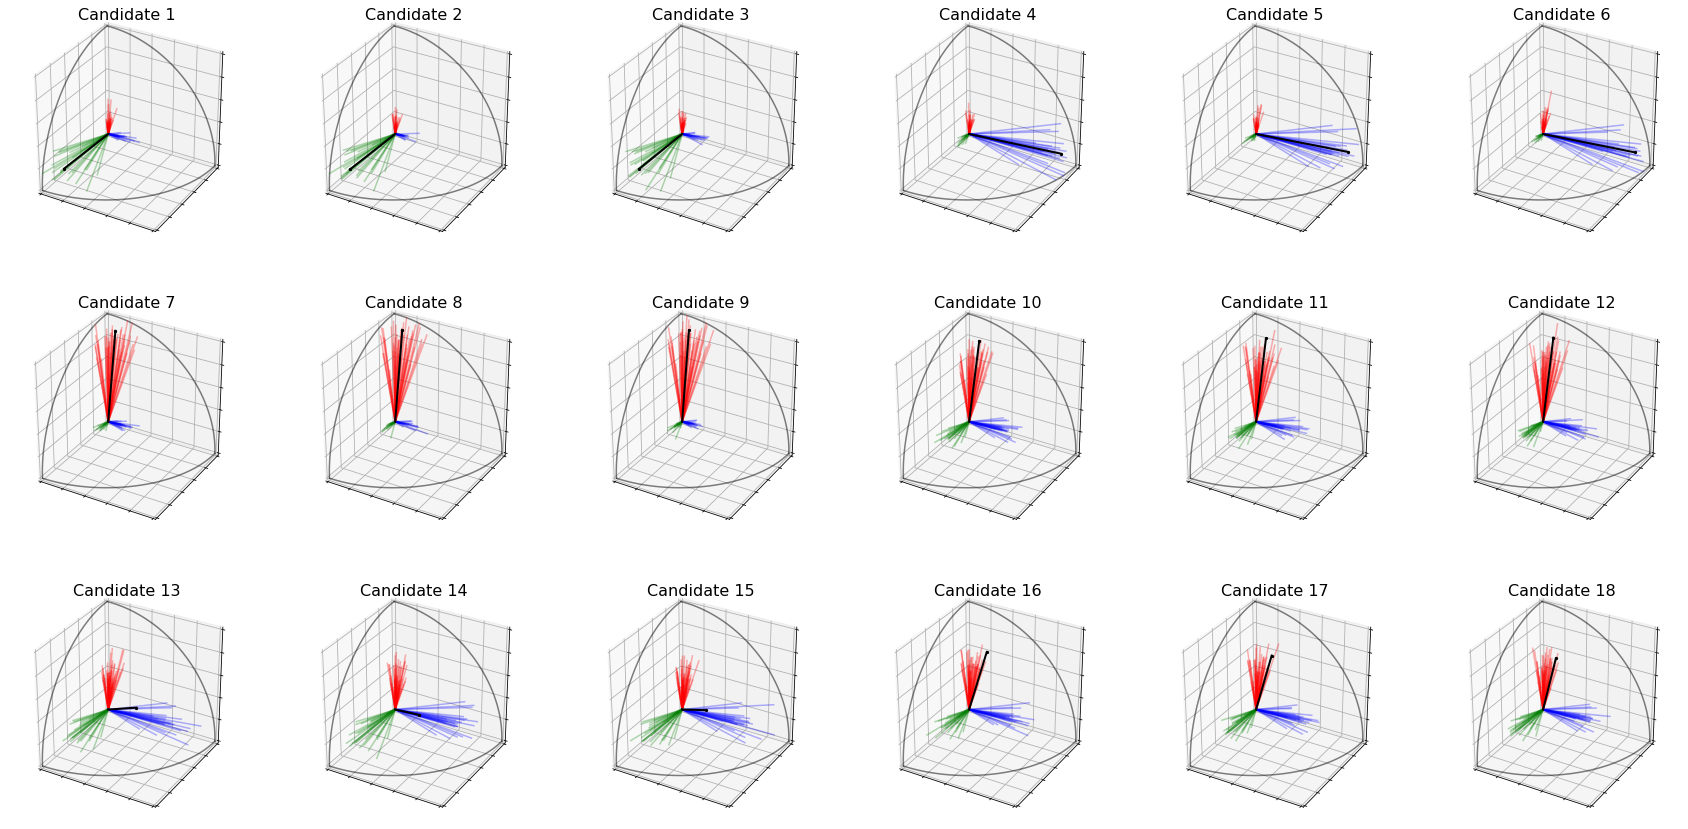

In [5]:
itersvd.plot_vectors()

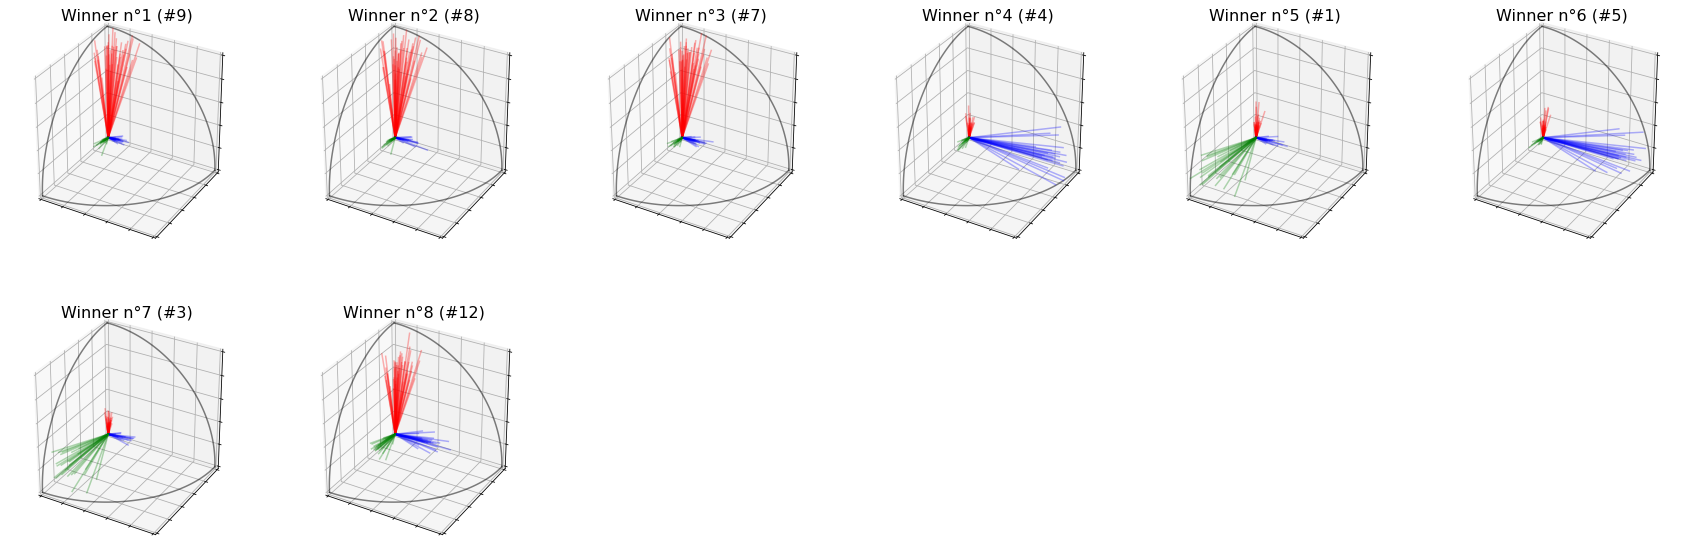

In [6]:
itersvd = IterSVD(profile=p,k=8,agg_rule=np.max)
itersvd.plot_winners()

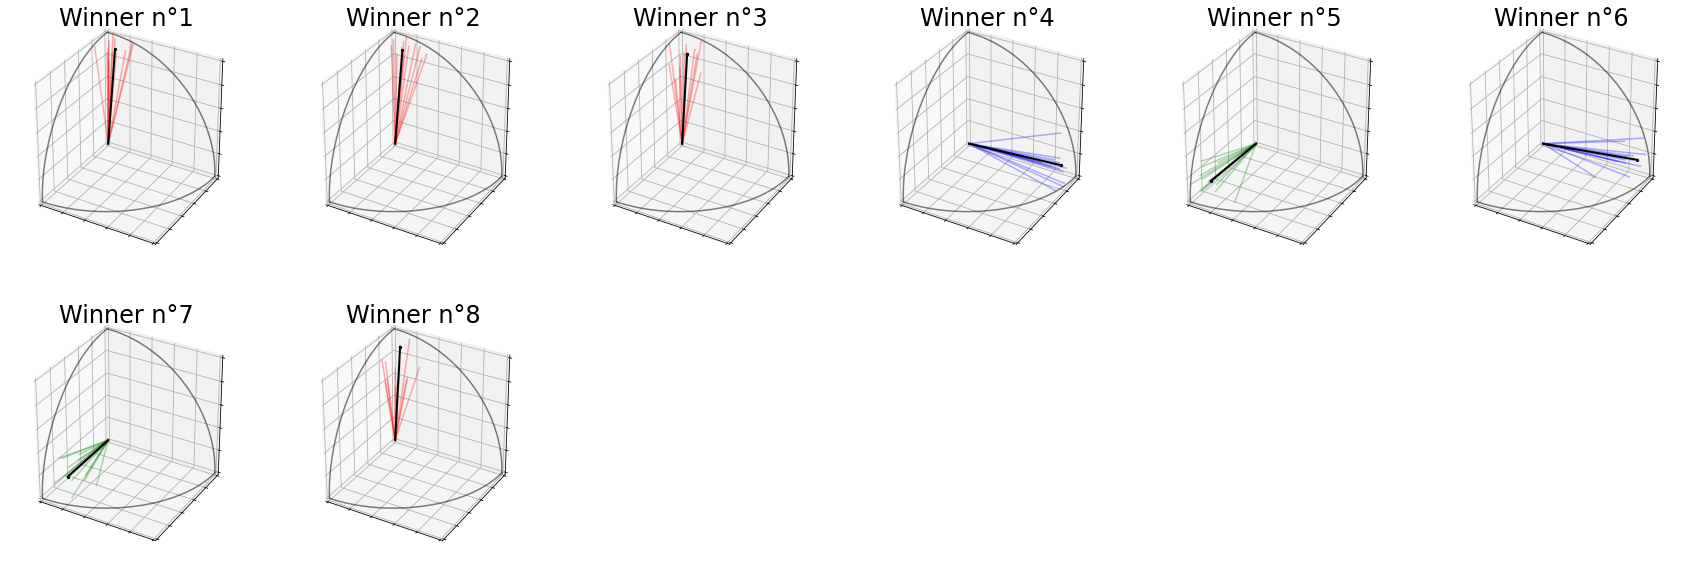

In [7]:
itersvd.plot_voters()

#### IterSVD with ponderation

A chaque étape, au lieu de supprimer totalement $\dfrac{n}{k}$ électeurs, on enlève un peu de poids à tous les électeurs pour atteindre un poids total de $\dfrac{n}{k}$. Il y a quelques pertes lorsqu'on veut enlever un poids supérieur au poid existant, mais cela est negligeable.

Il y a 2 quotas possibles :
* **Classique** $\dfrac{n}{k}$
* **Droop** $\dfrac{n}{k+1} +1$

Et les versions *_MIN* où l'on prends le minimum :

$$
Q = \min(Q,\sum_i s_i w_i)
$$

In [22]:
#quota in [CLASSIC_QUOTA, DROOP_QUOTA, CLASSIC_QUOTA_MIN, DROOP_QUOTA_MIN]

In [18]:
witersvd = WeightedIterSVD(profile=p,k=8,quota=CLASSIC_QUOTA,agg_rule=np.prod)

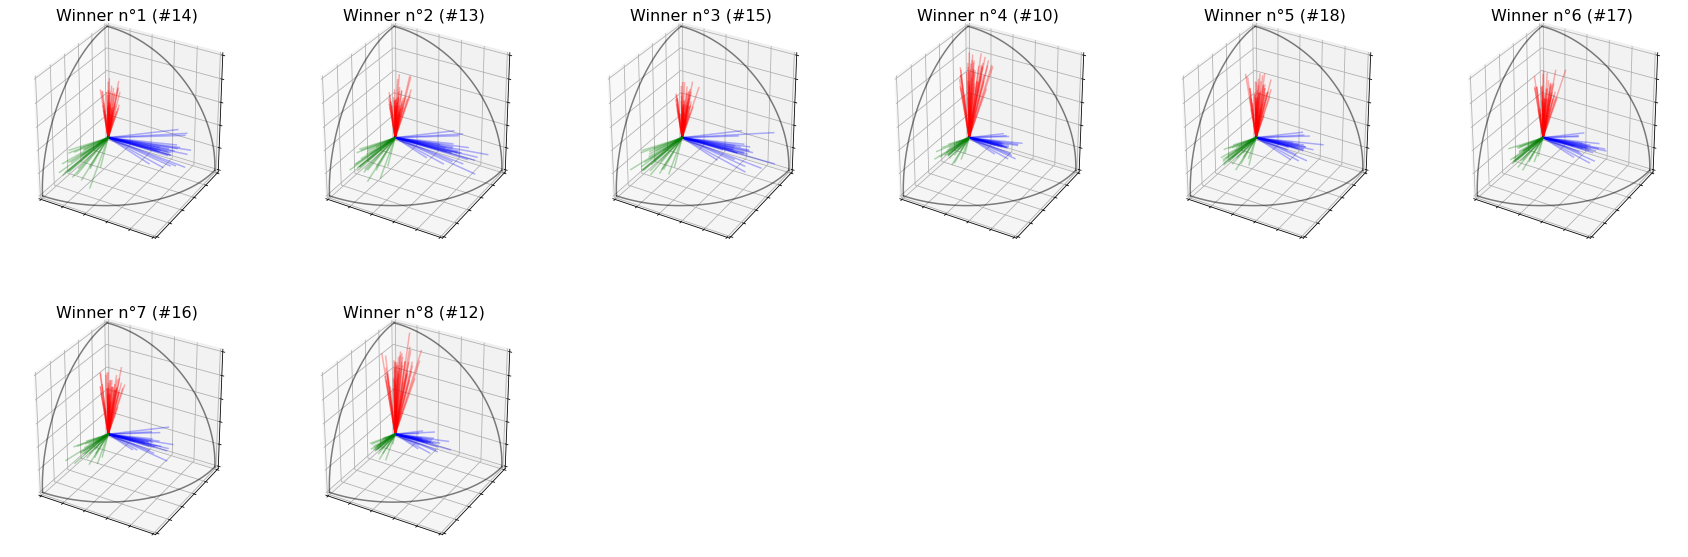

In [19]:
witersvd.plot_winners()

Weight / remaining candidate :  [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 15.610322588225545]


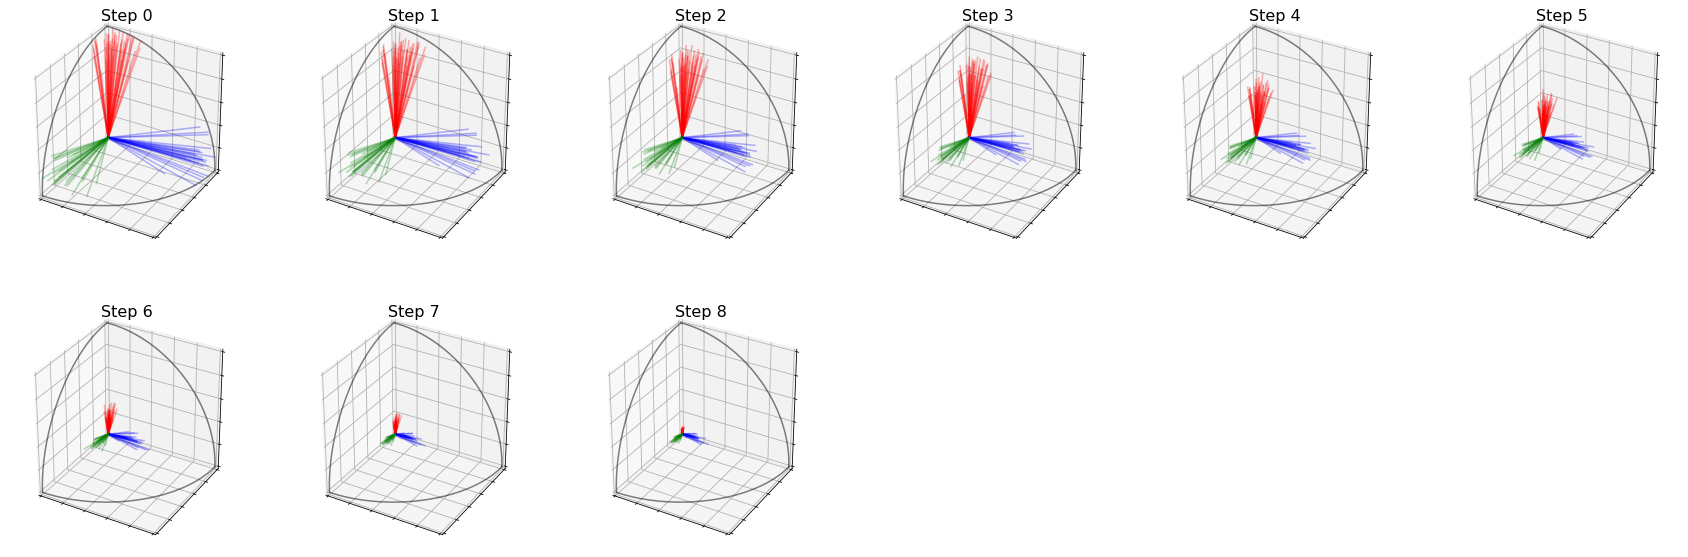

In [20]:
witersvd.plot_weights()

In [21]:
np.average(witersvd.weights)

0.09410920337938825

### 5.C. IterFeatures

La mécanique est la même que dans la partie précédente. Pour ce qui est du critère de sélection il y a deux possibilité qui vont nous donner des candidats polarisés :

1. La somme des carrés
2. La règle du cosinus


La première à l'élégance d'être très simple, la seconde semble cependant plus adapté au problème, d'autant plus qu'il est très simple de dériver une fonction de satisfaction de cette règle. Comme on peut le voir ci dessous, la règle des carrés semble plus efficace si l'on cherche une répartition proportionnelle des vainqueurs.

Le vecteur de features n'est pas forcément dans l'orthan positif ! Cela risque de poser problème pour la version continue de IterFeatures.

#### Règle du cosinus

In [26]:
iterfeatures = IterFeatures(profile=p,k=8)

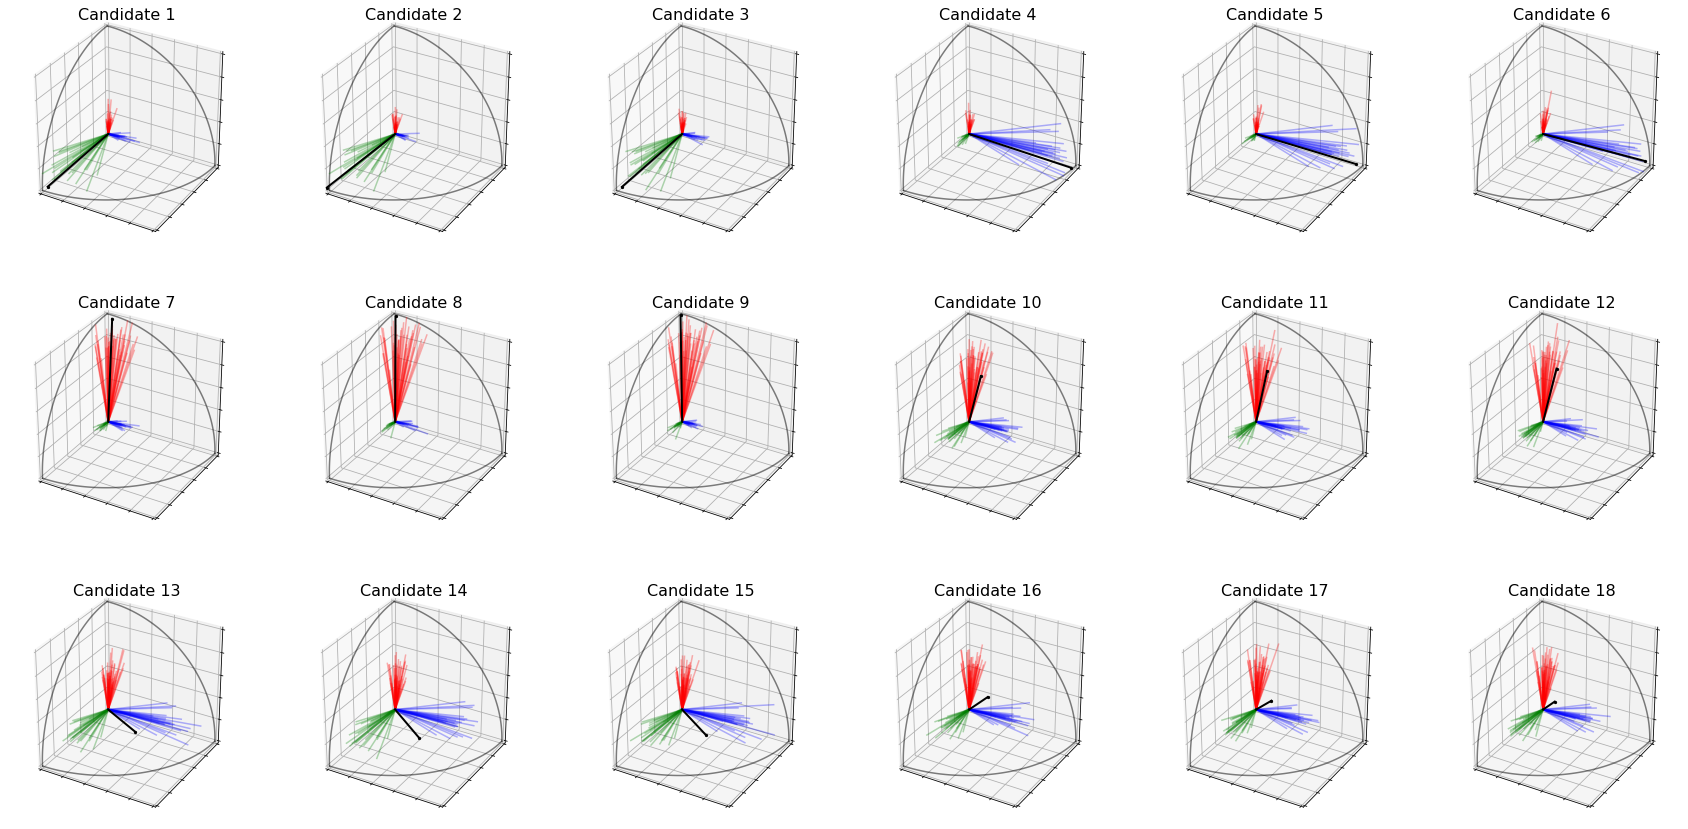

In [27]:
iterfeatures.plot_vectors()

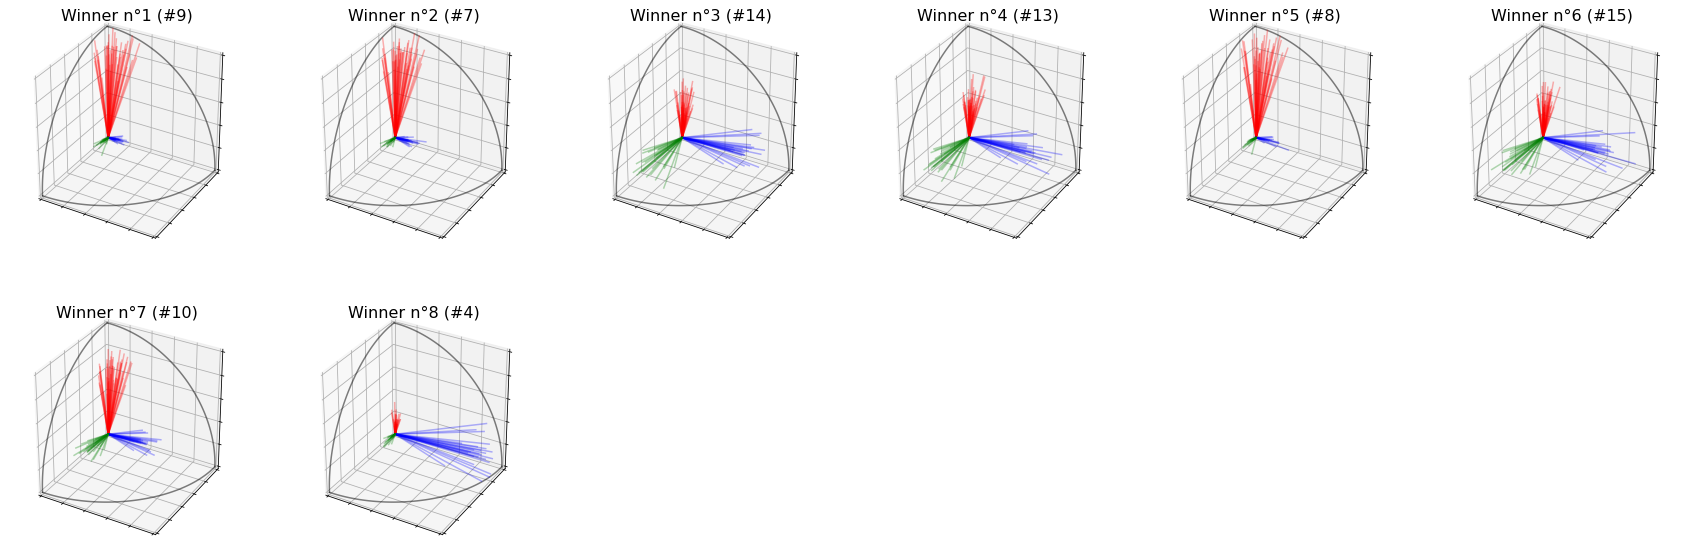

In [28]:
iterfeatures.plot_winners()

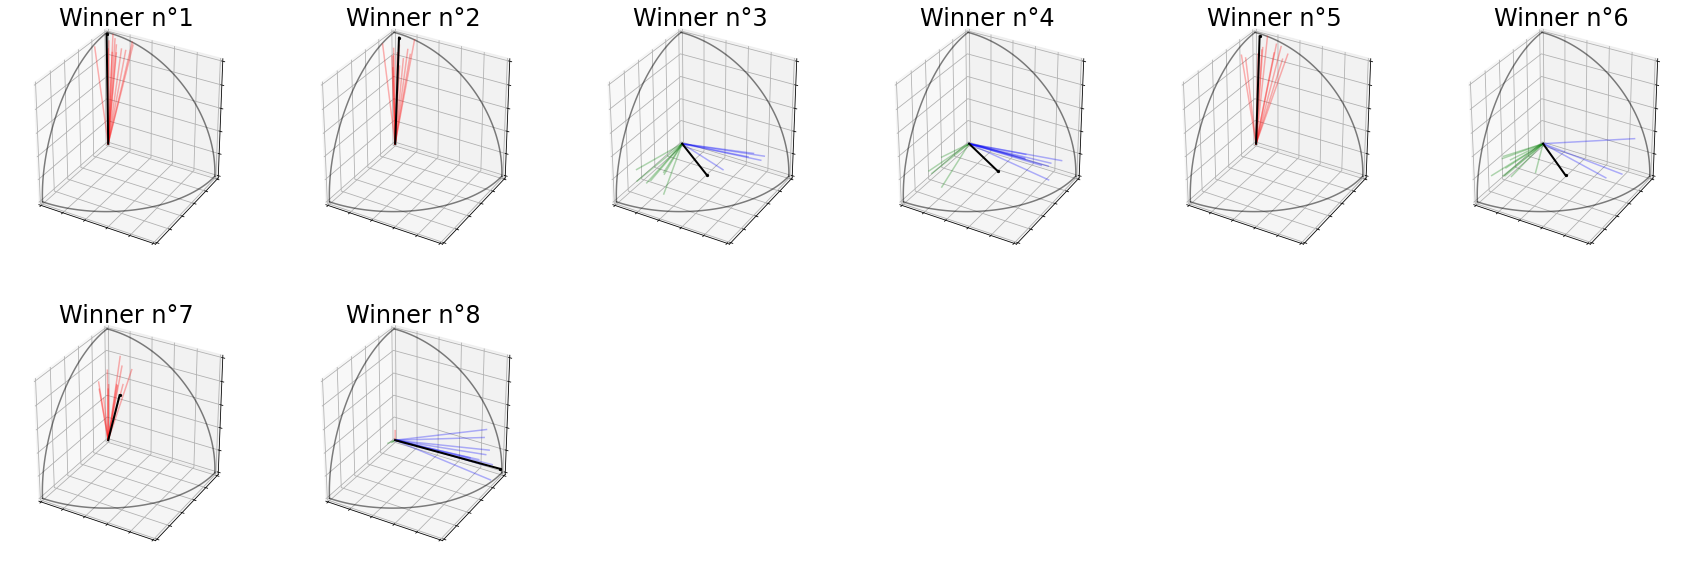

In [29]:
iterfeatures.plot_voters()

#### Somme des carrés

In [30]:
siterfeatures = SquareIterFeatures(profile=p,k=8)

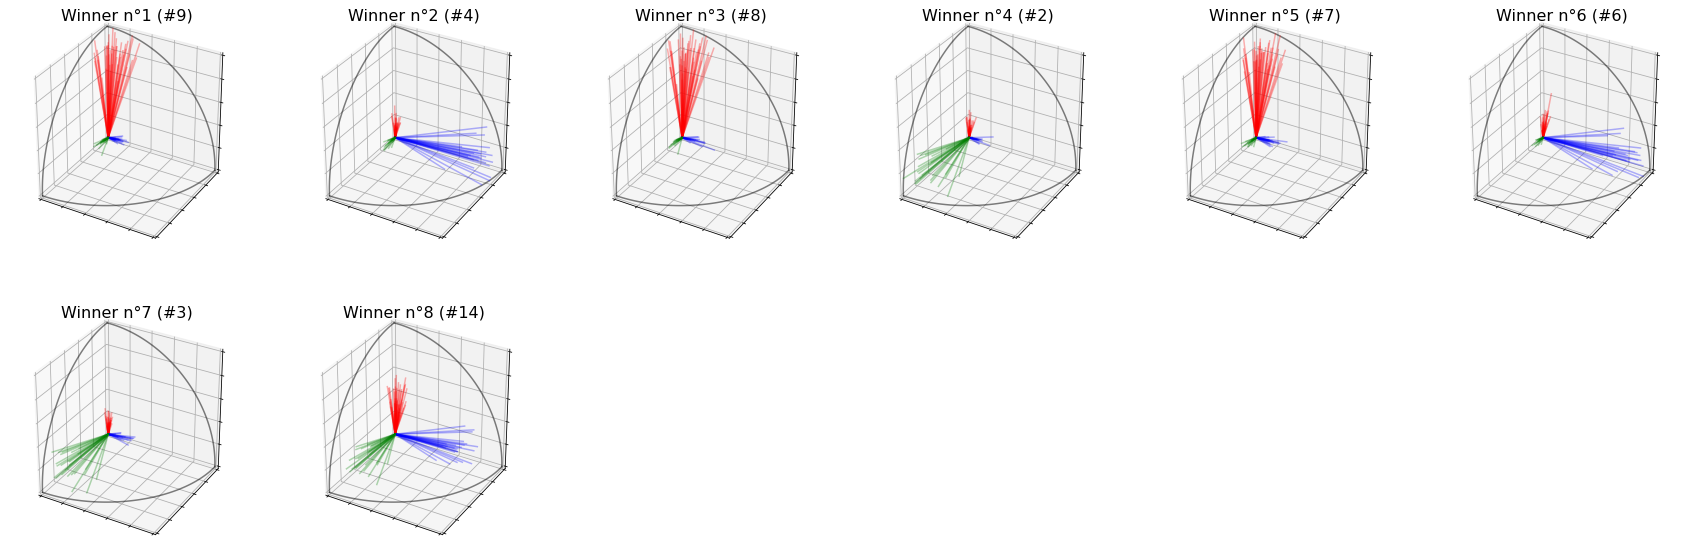

In [31]:
siterfeatures.plot_winners()

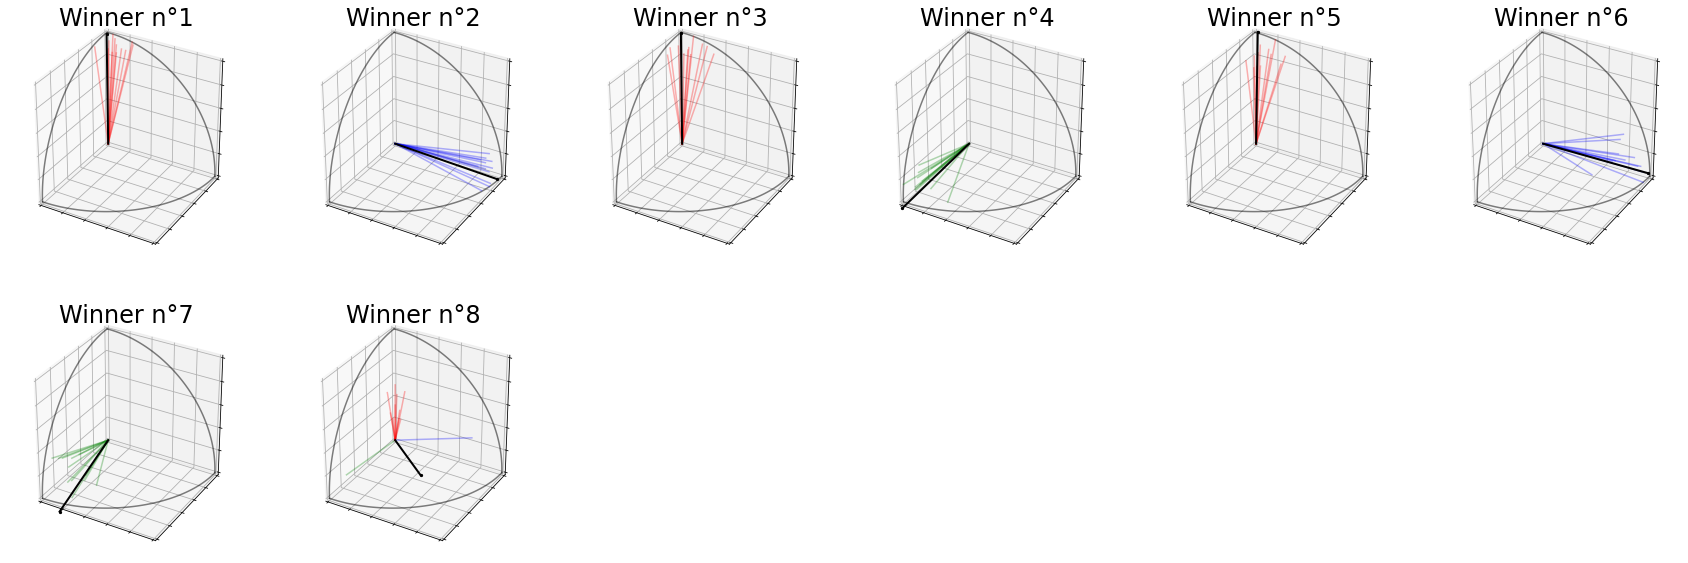

In [32]:
siterfeatures.plot_voters()

#### Règle du cosinus Weighted

In [33]:
witerfeatures = WeightedIterFeatures(profile=p,k=8)

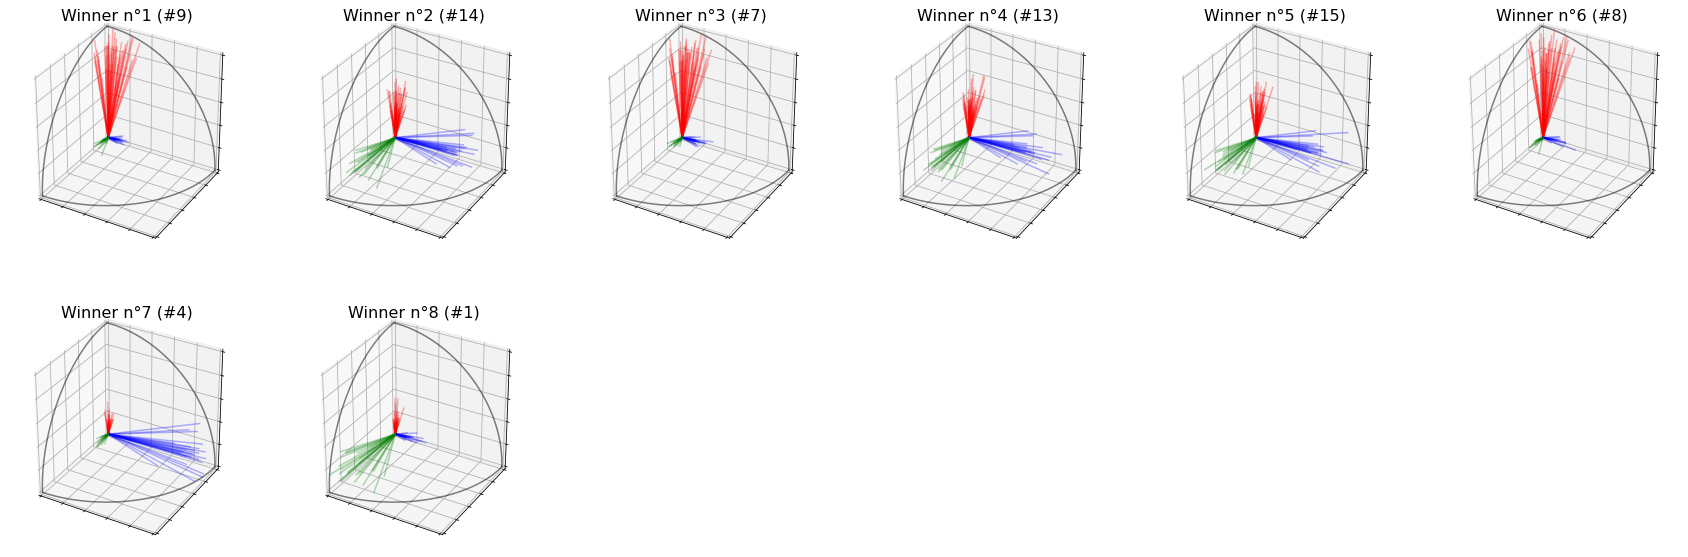

In [34]:
witerfeatures.plot_winners()

Weight / remaining candidate :  [12.5, 12.5, 12.499999999999995, 12.500000000000002, 12.499999999999998, 12.5, 12.5, 15.952854999723924]


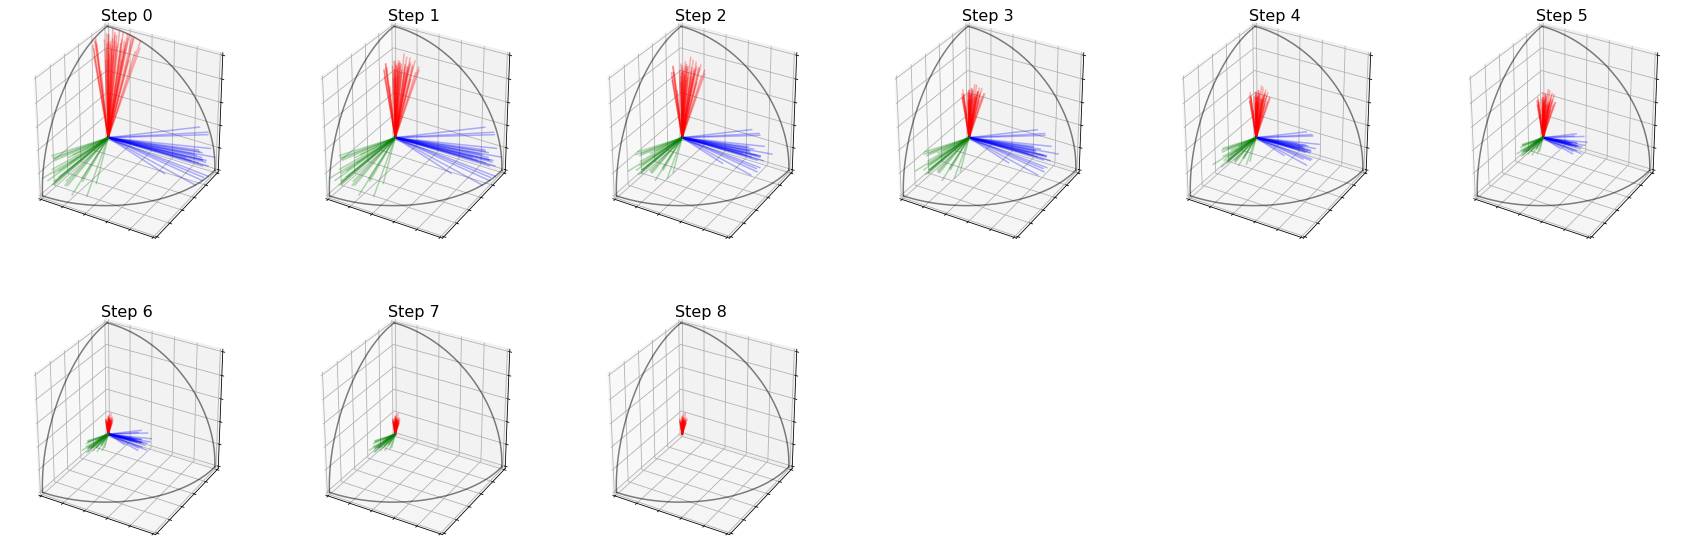

In [35]:
witerfeatures.plot_weights()

In [36]:
np.average(witerfeatures.weights)

0.0735262284742709

#### Somme des carrés weighted

In [37]:
wsiterfeatures = WeightedSquareIterFeatures(profile=p,k=8)

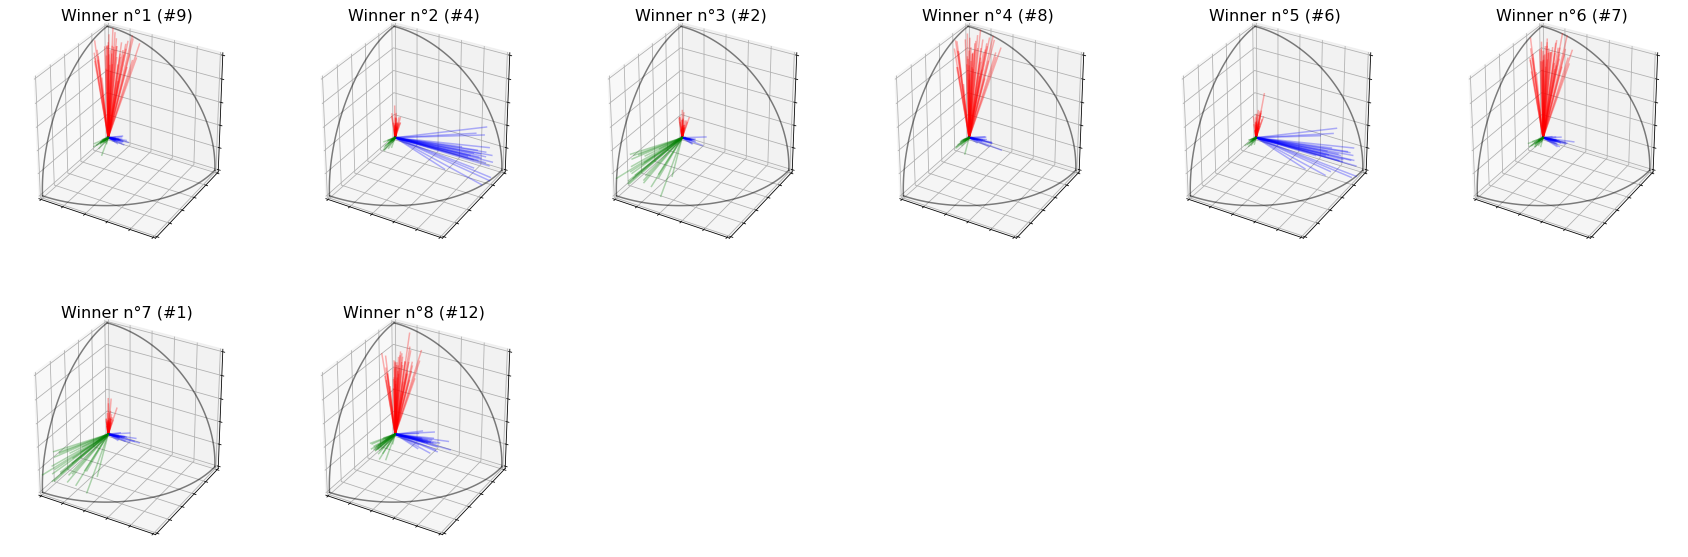

In [38]:
wsiterfeatures.plot_winners()

Weight / remaining candidate :  [12.5, 12.5, 12.5, 12.5, 12.5, 12.58281410372018, 12.624221155580267, 13.511474969926304]


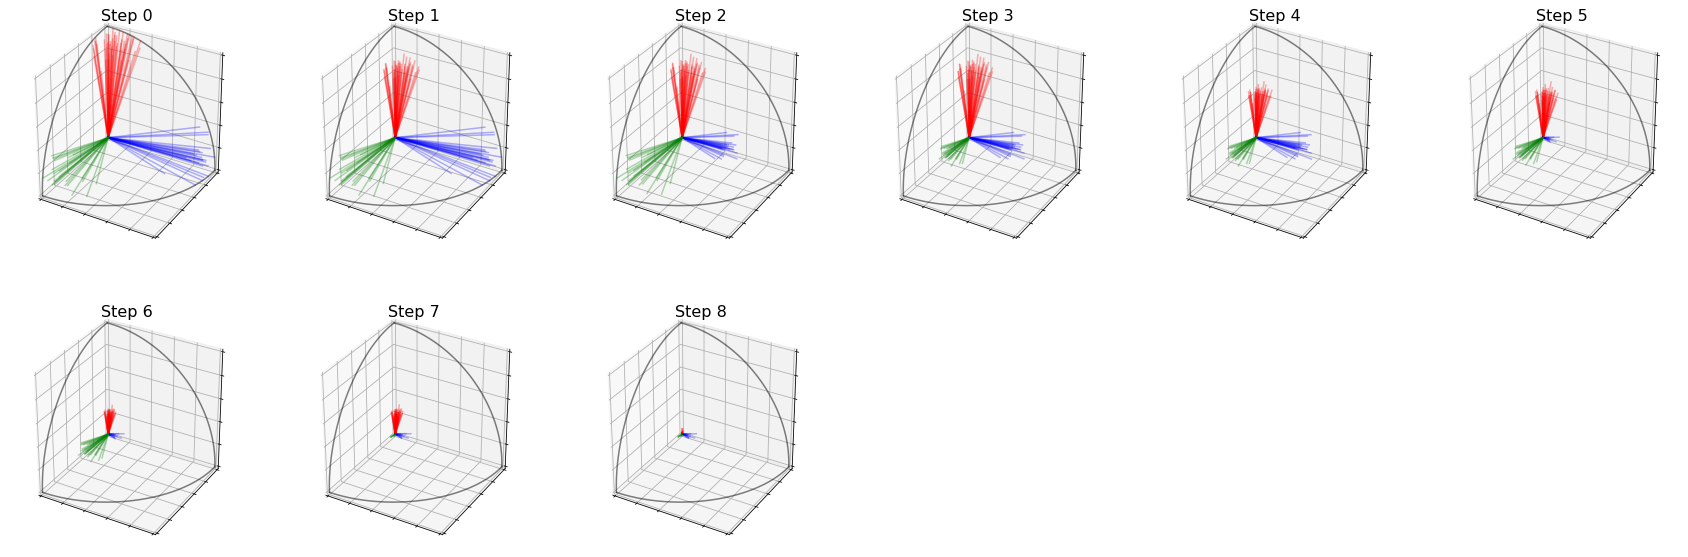

In [39]:
wsiterfeatures.plot_weights()

In [40]:
np.average(wsiterfeatures.weights)

0.02036516670209319

### 5.D. IterMax

On pourrait penser qu'il est plus malin de faire la même chose, mais en prenant le vecteur qui maximize la condition suivante plutot que d'utiliser un SVD :
$$
\max_{\left \| x \right \| = 1} \sum s_i(c)<\vec{v^i},\vec{x}> =  <\vec{x},\sum s_i(c)\vec{v^i}> = \dfrac{\sum s_i(c) \vec{v^i}}{\left \| \sum s_i(c) \vec{v^i} \right \| }
$$

Cependant, ce vecteur est moins representatif d'un groupe, et beaucoup plus *"centriste"*


## 6. The moving voter

Dans les cellules suivantes, nous avons un profil de 4 électeurs et 4 candidats : 

* 1 électeur qui a pour coordonéées $[1,0,0]$ et qui aime uniquement le candidat $1$ avec poids $1$ et le candidat du consensus $4$ avec un poids $0.5$.
* 1 électeur qui a pour coordonéées $[0,1,0]$ et qui aime uniquement le candidat $2$ avec poids $1$ et le candidat du consensus $4$ avec un poids $0.5$.
* 1 électeur qui a pour coordonéées $[0,0,1]$ et qui aime uniquement le candidat $3$ avec poids $1$ et le candidat du consensus $4$ avec un poids $0.5$.
* 1 électeur qui va changer de coordonnées, entre $[1,0,0]$ et $[0,1,0]$. Il aime tous les candidats avec un poids $0.75$.



<img src="../Figures/schémas_embeddings/schema3.jpg">

Dans les graphiques qui suivent :

* <font color=blue>Start</font> correspond au score du candidat apprécié par l'électeur de départ (le jaune sur le schéma ci-dessus).
* <font color=orange>End</font> correspond au score du candidat apprécié par l'électeur de fin (le bleu sur le schéma ci-dessus).
* <font color=green>Orth</font> correspond au score du candidat apprécié par l'électeur orthogonal (le rouge sur le schéma ci-dessus).
* <font color=red>Consensus</font> correspond au score du candidat un peu apprécié par tout le monde.

### Evolution of the scores of every candidate with different rules

In [50]:
from embedded_voting.analysis import MovingVoter

In [51]:
mv = MovingVoter()

Les règles basées sur le volume (Zonotope, Produit de SVD), donneront un score positif uniquement au candidat du consensus car c'est le seul avec un volume en 3D

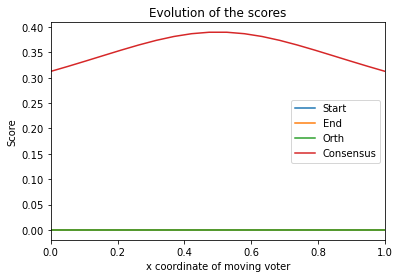

In [52]:
z = ZonotopeRule()
mv(z).plot_evol()

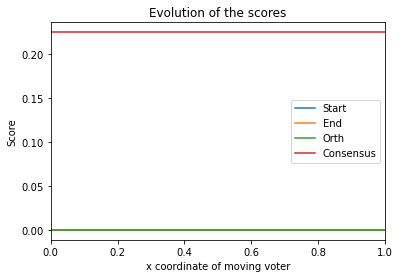

In [53]:
z = SVDRule(agg_rule=np.prod)
mv(z).plot_evol()

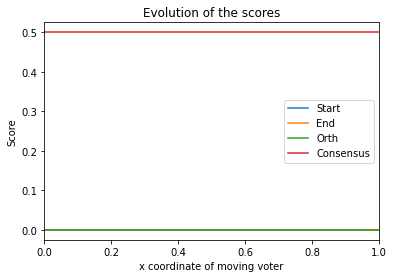

In [54]:
z = SVDRule(agg_rule=np.min)
mv(z).plot_evol()

Pour la règle de SVD, la **somme** et le **max** ont l'air de fonctionne à l'envers

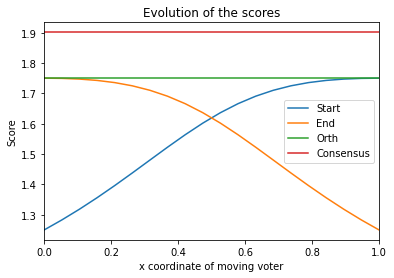

In [55]:
z = SVDRule(agg_rule=np.sum)
mv(z).plot_evol()

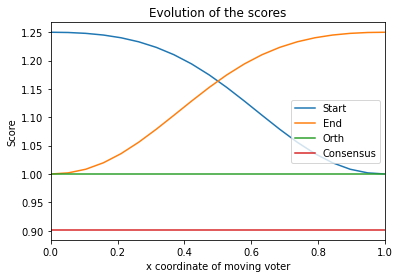

In [56]:
z = SVDRule(agg_rule=np.max)
mv(z).plot_evol()

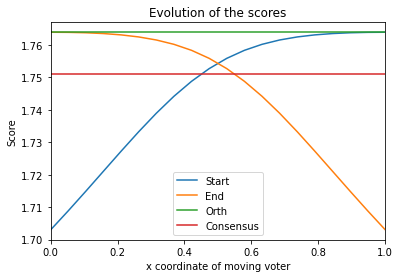

In [57]:
z = SVDRule(agg_rule=np_logsumexp)
mv(z).plot_evol()

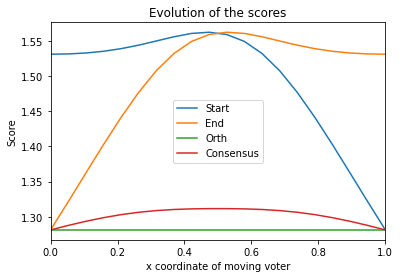

In [58]:
z = FeaturesRule(log=False,sin=False)
mv(z).plot_evol()

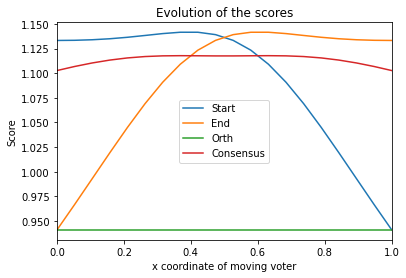

In [59]:
z = FeaturesRule(log=True,sin=False)
mv(z).plot_evol()

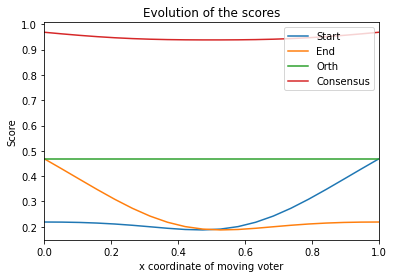

In [60]:
z = FeaturesRule(log=False,sin=True)
mv(z).plot_evol()

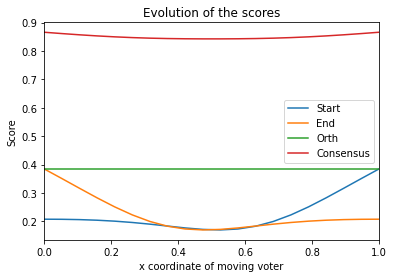

In [61]:
z = FeaturesRule(log=True,sin=True)
mv(z).plot_evol()

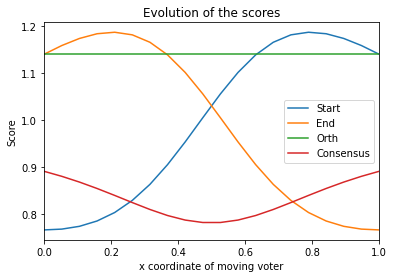

In [62]:
z = SquareFeaturesRule()
mv(z).plot_evol()

### Evolution of the embeddings of the different candidates with SVD and Features

In [63]:
from embedded_voting.analysis import MovingVoterFeatures

In [64]:
mvf = MovingVoterFeatures()

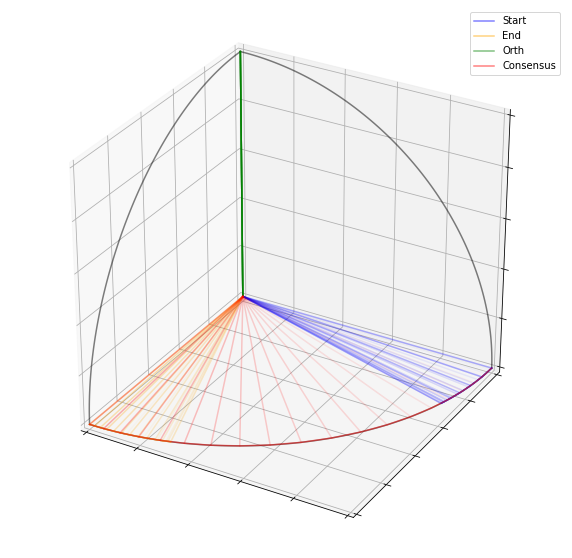

In [65]:
z = IterSVD()
mvf(z).plot_evol()

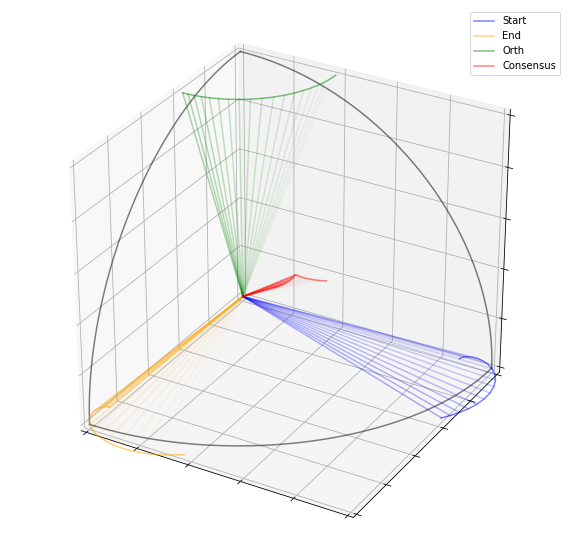

In [66]:
z = IterFeatures()
mvf(z).plot_evol()